<a href="https://colab.research.google.com/github/Advay-21/College_Experiments/blob/main/Recommender_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment 2

**Content based Recommendation**

In [ ]:
import pandas as pd
''' A tool from scikit-learn to convert text data into numerical features using the TF-IDF (Term Frequency-Inverse Document Frequency) technique,
which helps in identifying the importance of words in documents.'''
from sklearn.feature_extraction.text import TfidfVectorizer
#A metric used to measure the similarity between two non-zero vectors, commonly used in text similarity and recommendation systems.
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Load Movies Metadata
metadata = pd.read_csv('/content/movies_metadata.csv', low_memory=False)

In [ ]:
# Print the first three rows
metadata.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


In [ ]:
print(metadata.head())

   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                   NaN   8844  tt0113497         

In [ ]:
# Calculate mean of vote average column
C = metadata['vote_average'].mean()
print('Mean of Vote Average Column:',C)

Mean of Vote Average Column: 5.618207215134185


The quantile(0.90) function calculates the 90th percentile of the vote_count column.

This means 90% of the movies have a vote count less than or equal to this value, and only the top 10% of movies have more votes than this threshold.

In recommendation systems, this helps to filter out movies with very few votes, which might not be reliable for making quality recommendation.

If the vote counts for movies range from 10 to 20,000, the 90th percentile might be around 15,000 votes. This means only movies with 15,000 or more votes will be considered for the chart.

In [ ]:
# Calculate the minimum number of votes required to be in the chart, m
m = metadata['vote_count'].quantile(0.90)
print('Minimum number of votes required to be in the chart:',m)

Minimum number of votes required to be in the chart: 160.0


**metadata.copy():** This creates a copy of the original metadata DataFrame.
It ensures that the original dataset remains unchanged, which is good practice when modifying data.

**.loc[metadata['vote_count'] >= m]:** The .loc[] function is used for label-based indexing to filter rows based on conditions.
The condition metadata['vote_count'] >= m filters for movies where the vote_count is greater than or equal to the threshold m (which represents the 90th percentile of votes).
This effectively selects only the "qualified" movies—those with enough votes to be statistically significant.

**q_movies =** The filtered DataFrame is stored in a new variable, q_movies, which contains only the movies that passed the vote count threshold.
q_movies.shape

The .shape attribute returns the dimensions of the q_movies DataFrame as a tuple

In [ ]:
# Filter out all qualified movies into a new DataFrame
q_movies = metadata.copy().loc[metadata['vote_count'] >= m]
q_movies.shape

(4555, 24)

In [ ]:
metadata.shape

(45466, 24)

Defines a function named weighted_rating that takes:
x: A row from the movie dataset (likely passed using .apply() later).
m: The minimum number of votes required to be considered (calculated earlier).
C: The mean (average) vote across all movies (this should be defined elsewhere in the code).

**v = x['vote_count']:** Retrieves the number of votes (vote_count) for the specific movie x.

**R = x['vote_average']:** Retrieves the average rating (vote_average) for the movie x.
This formula balances the movie's actual rating with the global average rating based on the number of votes.

**(v / (v + m)) * R:**
This part weights the movie’s own rating (R) based on how many votes it has (v).
More votes = greater influence on the final score.

**(m / (m + v)) * C:**
This part adds the global average rating (C), weighted by the minimum votes required (m).

In [ ]:
# Function that computes the weighted rating of each movie
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

Adds a new column called score to the q_movies DataFrame, where each movie's score is calculated using the weighted_rating() function. This score helps rank the movies based on both their average rating and the number of votes they’ve received.

In [ ]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

In [ ]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

In [ ]:
# Print the top 10 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
314,The Shawshank Redemption,8358.0,8.5,8.445869
834,The Godfather,6024.0,8.5,8.425439
10309,Dilwale Dulhania Le Jayenge,661.0,9.1,8.421453
12481,The Dark Knight,12269.0,8.3,8.265477
2843,Fight Club,9678.0,8.3,8.256385
292,Pulp Fiction,8670.0,8.3,8.251406
522,Schindler's List,4436.0,8.3,8.206639
23673,Whiplash,4376.0,8.3,8.205404
5481,Spirited Away,3968.0,8.3,8.196055
2211,Life Is Beautiful,3643.0,8.3,8.187171


**Content-Based Recommender**

Plot Description Based Recommender

In [ ]:
#Print plot overviews of the first 5 movies.
metadata['overview'].head()

,overview
0,"Led by Woody, Andy's toys live happily in his ..."
1,When siblings Judy and Peter discover an encha...
2,A family wedding reignites the ancient feud be...
3,"Cheated on, mistreated and stepped on, the wom..."
4,Just when George Banks has recovered from his ...


In [ ]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

In [ ]:
#Replace NaN with an empty string
metadata['overview'] = metadata['overview'].fillna('')

In [ ]:
# Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(metadata['overview'])

In [ ]:
# Output the shape of tfidf_matrix
tfidf_matrix.shape

(45466, 75827)

In [ ]:
#Array mapping from feature integer indices to feature name.
tfidf.get_feature_names_out()[5000:5010]

array(['avails', 'avaks', 'avalanche', 'avalanches', 'avallone', 'avalon',
       'avant', 'avanthika', 'avanti', 'avaracious'], dtype=object)

In [ ]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

In [ ]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
cosine_sim.shape

(45466, 45466)

In [ ]:
cosine_sim[1]

array([0.01504121, 1.        , 0.04681953, ..., 0.        , 0.02198641,
       0.00929411])

In [ ]:
# Convert the cosine similarity matrix to a DataFrame for better readability
cosine_sim_df = pd.DataFrame(cosine_sim, index=metadata['title'], columns=metadata['title'])
# Display the first 5 rows and 5 columns
cosine_sim_df.iloc[:5, :5]

title,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II
title,,,,,
Toy Story,1.000000,0.015041,0.000000,0.0,0.000000
Jumanji,0.015041,1.000000,0.046820,0.0,0.000000
Grumpier Old Men,0.000000,0.046820,1.000000,0.0,0.025094
Waiting to Exhale,0.000000,0.000000,0.000000,1.0,0.000000
Father of the Bride Part II,0.000000,0.000000,0.025094,0.0,1.000000


In [ ]:
print(cosine_sim_df.head())

title                        Toy Story   Jumanji  Grumpier Old Men  \
title                                                                
Toy Story                     1.000000  0.015041          0.000000   
Jumanji                       0.015041  1.000000          0.046820   
Grumpier Old Men              0.000000  0.046820          1.000000   
Waiting to Exhale             0.000000  0.000000          0.000000   
Father of the Bride Part II   0.000000  0.000000          0.025094   

title                        Waiting to Exhale  Father of the Bride Part II  \
title                                                                         
Toy Story                                  0.0                     0.000000   
Jumanji                                    0.0                     0.000000   
Grumpier Old Men                           0.0                     0.025094   
Waiting to Exhale                          1.0                     0.000000   
Father of the Bride Part II        

In [ ]:
# Construct a reverse map of indices and movie titles
indices = pd.Series(metadata.index, index=metadata['title']).drop_duplicates()

In [ ]:
indices[:10]

,0
title,
Toy Story,0
Jumanji,1
Grumpier Old Men,2
Waiting to Exhale,3
Father of the Bride Part II,4
Heat,5
Sabrina,6
Tom and Huck,7
Sudden Death,8


In [ ]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    # Return the top 10 most similar movies
    return metadata['title'].iloc[movie_indices]

In [ ]:
get_recommendations('The Godfather')

,title
1178,The Godfather: Part II
44030,The Godfather Trilogy: 1972-1990
1914,The Godfather: Part III
23126,Blood Ties
11297,Household Saints
34717,Start Liquidation
10821,Election
38030,A Mother Should Be Loved
17729,Short Sharp Shock
26293,Beck 28 - Familjen


In [ ]:
get_recommendations('Forrest Gump')

,title
10966,An American Haunting
13513,Nigdy w życiu!
22372,The Lost Thing
31468,Carver
9214,Crane World
19554,The Marshal of Finland
29006,For a Handful of Kisses
39672,U Be Dead
40018,Down by Love
30256,Lucky 13


# Experiment 3.1

In [ ]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Load dataset
#Specifies four categories from the 20 Newsgroups dataset
categories = ['sci.space', 'rec.autos', 'comp.graphics', 'talk.politics.mideast']
#Loads all articles from the selected categories.
newsgroups = fetch_20newsgroups(subset='all', categories=categories)

In [ ]:
# Split dataset
'''Splits the dataset into training (80%) and testing (20%) sets.
newsgroups.data: The list of text documents.
newsgroups.target: Labels (0, 1, 2, or 3, corresponding to the categories).
random_state=42: Ensures reproducibility of results.'''
X_train, X_test, y_train, y_test = train_test_split(newsgroups.data, newsgroups.target, test_size=0.2, random_state=42)

In [ ]:
# Convert text data to term frequency vectors
vectorizer = CountVectorizer() #Converts text documents into a word frequency matrix.
X_train_counts = vectorizer.fit_transform(X_train) #Learns the vocabulary and transforms training data into a sparse matrix.
X_test_counts = vectorizer.transform(X_test) #Converts test data using the learned vocabulary

In [ ]:
# Compute class prior probabilities
class_counts = np.bincount(y_train) #Counts occurrences of each class label in y_train
class_prior = class_counts / len(y_train) #calculates prior probabilities for each class

In [ ]:
# Compute word likelihoods
alpha = 1  # Applies Laplace smoothing to prevent zero probabilities.
word_counts = np.zeros((len(categories), X_train_counts.shape[1])) + alpha #formula as per the numerical

In [ ]:
#Iterates over each unique class (c) and Sums the word counts for all training samples in that class.
for i, c in enumerate(np.unique(y_train)):
    word_counts[i, :] += X_train_counts[y_train == c].toarray().sum(axis=0)

In [ ]:
#Computes word likelihood for each word in each class
word_prob = word_counts / word_counts.sum(axis=1, keepdims=True)

In [ ]:
# Predict function using Naïve Bayes formula
'''vectorizer.transform([text]): Converts the input text into a feature vector.
np.log(class_prior): Computes log of prior probabilities.
np.dot(np.log(word_prob), text_counts):
Multiplies word probabilities (log scale) with word frequencies in the input text.
np.argmax(log_probs): Returns the class with the highest probability.'''
def predict(text):
    text_counts = vectorizer.transform([text]).toarray()[0]
    log_probs = np.log(class_prior) + np.dot(np.log(word_prob), text_counts)
    return np.argmax(log_probs)

In [ ]:
# Test recommendation
sample_text = "NASA launched a new satellite for deep space exploration."
predicted_category = predict(sample_text)
print(f"Recommended category: {newsgroups.target_names[predicted_category]}")

Recommended category: sci.space


# Experiment 3.2

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Load IMDB dataset
file_path = "/content/IMDB Dataset.csv"
df = pd.read_csv(file_path)

In [ ]:
# Encode sentiment labels: 'positive' → 1, 'negative' → 0
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [ ]:
# Split dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)

In [ ]:
# Convert text data to term frequency vectors
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

In [ ]:
# Compute class prior probabilities
class_counts = np.bincount(y_train)
class_prior = class_counts / len(y_train)

In [ ]:
# Compute word likelihoods with Laplace smoothing
alpha = 1
word_counts = np.zeros((2, X_train_counts.shape[1])) + alpha  # 2 classes: positive and negative
for i, c in enumerate(np.unique(y_train)):
    word_counts[i, :] += X_train_counts[y_train == c].toarray().sum(axis=0)
word_prob = word_counts / word_counts.sum(axis=1, keepdims=True)

In [ ]:
# Predict function using Naïve Bayes formula
def predict(text):
    text_counts = vectorizer.transform([text]).toarray()[0]
    log_probs = np.log(class_prior) + np.dot(np.log(word_prob), text_counts)
    return np.argmax(log_probs)

In [ ]:
# Evaluate the model
y_pred = [predict(text) for text in X_test]
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

Model Accuracy: 0.8488
              precision    recall  f1-score   support

    Negative       0.83      0.88      0.85      4961
    Positive       0.87      0.82      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [ ]:
# Test recommendation
sample_review = input("Enter your review: ")
predicted_sentiment = predict(sample_review)
print(f"Predicted Sentiment: {'Positive' if predicted_sentiment == 1 else 'Negative'}")

Enter your review: The hero played his role well. The director did is job well. What more do you want? Great experience
Predicted Sentiment: Positive


In [ ]:
# Test recommendation
sample_review = input("Enter your review: ")
predicted_sentiment = predict(sample_review)
print(f"Predicted Sentiment: {'Positive' if predicted_sentiment == 1 else 'Negative'}")

Enter your review: Sadly, I wished the ending could have been better. The viewers were so confused. It needs improvement
Predicted Sentiment: Negative


# Experiment 4.1

In [ ]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Load dataset
categories = ['sci.space', 'rec.autos', 'comp.graphics', 'talk.politics.mideast']
newsgroups = fetch_20newsgroups(subset='all', categories=categories)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(newsgroups.data)

In [ ]:
# Initialize query vector (example query)
query_text = "NASA is planning a new space mission."
query_vec = vectorizer.transform([query_text])

In [ ]:
# Compute initial cosine similarity scores
similarity_scores = cosine_similarity(query_vec, X)[0]
ranked_indices = np.argsort(similarity_scores)[::-1]  # Sort in descending order

In [ ]:
# Select top documents for relevance feedback
relevant_docs = ranked_indices[:5]
irrelevant_docs = ranked_indices[-5:]

In [ ]:
# Rocchio Algorithm Parameters
alpha = 1  # Weight for original query
beta = 0.75  # Weight for relevant documents
gamma = 0.25  # Weight for irrelevant documents

In [ ]:
# Compute updated query vector using Rocchio's formula
relevant_vecs = X[relevant_docs].mean(axis=0).A  # Convert to array
irrelevant_vecs = X[irrelevant_docs].mean(axis=0).A  # Convert to array

In [ ]:
new_query_vec = alpha * query_vec.toarray() + beta * relevant_vecs - gamma * irrelevant_vecs # Convert query_vec to a NumPy array using .toarray()
new_query_vec = np.asarray(new_query_vec)  # Ensure it's a numpy array

In [ ]:
# Compute new similarity scores with updated query
new_similarity_scores = cosine_similarity(new_query_vec, X)[0]
new_ranked_indices = np.argsort(new_similarity_scores)[::-1]

In [ ]:
# Display updated recommendations
print("Top recommended categories after Rocchio's Algorithm:")
for idx in new_ranked_indices[:5]:
    print(f"Document Index: {idx}, Category: {newsgroups.target_names[newsgroups.target[idx]]}")

Top recommended categories after Rocchio's Algorithm:
Document Index: 205, Category: sci.space
Document Index: 1836, Category: sci.space
Document Index: 611, Category: sci.space
Document Index: 1082, Category: sci.space
Document Index: 1829, Category: sci.space


# Experiment 4.2

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Load dataset
df = pd.read_csv('/content/df_file.csv')  # Change path if needed

In [ ]:
df.columns = ['Text', 'Label']  # Ensure correct column names
# Convert text to TF-IDF vectors
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df['Text'])

In [ ]:
# Define an initial user query (Example: A technology-related query)
query_text = "Latest advancements in artificial intelligence"
query_vec = vectorizer.transform([query_text])

In [ ]:
# Compute initial cosine similarity scores
similarity_scores = cosine_similarity(query_vec, X)[0]
ranked_indices = np.argsort(similarity_scores)[::-1]  # Sort in descending order

In [ ]:
# Select top documents for relevance feedback
relevant_docs = ranked_indices[:5]
irrelevant_docs = ranked_indices[-5:]

In [ ]:
# Rocchio Algorithm Parameters
alpha = 1    # Weight for original query
beta = 0.75  # Weight for relevant documents
gamma = 0.25 # Weight for irrelevant documents

In [ ]:
# Compute updated query vector using Rocchio's formula
relevant_vecs = X[relevant_docs].mean(axis=0).A  # Convert to array
irrelevant_vecs = X[irrelevant_docs].mean(axis=0).A  # Convert to array

In [ ]:
new_query_vec = alpha * query_vec.toarray() + beta * relevant_vecs - gamma * irrelevant_vecs
# Convert query_vec to a NumPy array using .toarray()
new_query_vec = np.asarray(new_query_vec)  # Ensure it's a numpy array

In [ ]:
# Compute new similarity scores with updated query
new_similarity_scores = cosine_similarity(new_query_vec, X)[0]
new_ranked_indices = np.argsort(new_similarity_scores)[::-1]

In [ ]:
# Display updated recommendations
print("\nTop recommended categories after Rocchio's Algorithm:")
for idx in new_ranked_indices[:5]:
    print(f"Document Index: {idx}, Category: {df.iloc[idx]['Label']}, Text: {df.iloc[idx]['Text'][:100]}...")


Top recommended categories after Rocchio's Algorithm:
Document Index: 378, Category: 0, Text: Russian ex-spy on hunger strike
 
 An ex-Russian intelligence officer who risked his life spying for...
Document Index: 2175, Category: 4, Text: Ukraine revisits state sell-offs
 
 Ukraine is preparing what could be a wholesale review of the pri...
Document Index: 2099, Category: 4, Text: Durex maker SSL awaits firm bid
 
 UK condom maker SSL International has refused to comment on repor...
Document Index: 70, Category: 0, Text: Butler launches attack on Blair
 
 Former civil service chief Lord Butler has criticised the way Ton...
Document Index: 1271, Category: 2, Text: Mobile gig aims to rock 3G
 
 Forget about going to a crowded bar to enjoy a gig by the latest darli...


# Experiment 5

In [ ]:
import pandas as pd

In [ ]:
# Load the datasets
ratings = pd.read_csv('/content/ratings (2).csv')
# Inspect the first few rows
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
movies = pd.read_csv('/content/movies (2).csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

In [ ]:
# Drop timestamp column
ratings.drop(columns=["timestamp"], inplace=True)

In [ ]:
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [ ]:
# Merge ratings with movie titles
movie_ratings = ratings.merge(movies, on="movieId")

In [ ]:
movie_ratings.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [ ]:
# Filter movies with few ratings (e.g., at least 3 ratings)
min_ratings = 3
filtered_movies = movie_ratings.groupby("title").filter(lambda x: len(x) >= min_ratings)

In [ ]:
filtered_movies.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [ ]:
# Create a movie-user matrix
movie_user_matrix = filtered_movies.pivot_table(index='title', columns='userId', values='rating').fillna(0)

In [ ]:
# Convert to sparse matrix for efficiency
movie_user_matrix_sparse = csr_matrix(movie_user_matrix)

In [ ]:
# Import cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Compute cosine similarity between movies
cosine_sim = cosine_similarity(movie_user_matrix_sparse)

In [ ]:
# Train k-NN model
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5)
knn.fit(movie_user_matrix_sparse)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
# Function to get similar movies
def get_movie_recommendations(movie_title, n_recommendations=5):
    if movie_title not in movie_user_matrix.index:
        return "Movie not found in dataset."
    movie_index = movie_user_matrix.index.get_loc(movie_title)
    distances, indices = knn.kneighbors(movie_user_matrix.iloc[movie_index, :].values.reshape(1, -1), n_neighbors=n_recommendations+1)
    similar_movies = [movie_user_matrix.index[i] for i in indices.flatten()[1:]]  # Exclude the first one (itself)
    return similar_movies

In [ ]:
# Example usage
movie_to_recommend = "Toy Story (1995)"
recommendations = get_movie_recommendations(movie_to_recommend)
print(f"Movies similar to '{movie_to_recommend}':")
for i in recommendations:
  print(i)

Movies similar to 'Toy Story (1995)':
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)


In [ ]:
# Example usage
movie_to_recommend = "Heat (1995)"
recommendations = get_movie_recommendations(movie_to_recommend)
print(f"Movies similar to '{movie_to_recommend}':")
for i in recommendations:
  print(i)

Movies similar to 'Heat (1995)':
Rock, The (1996)
Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
Léon: The Professional (a.k.a. The Professional) (Léon) (1994)
Casino (1995)
Fargo (1996)


# Experiment 6.1

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# Load the dataset (assuming it's in CSV format)
movies = pd.read_csv("/content/movie.csv")  # Movie dataset
ratings = pd.read_csv("/content/rating.csv")  # User ratings dataset

In [ ]:
# Merge movies and ratings dataset
movie_ratings = pd.merge(ratings, movies, on="movieId")

In [ ]:
# Calculate average rating for each movie
avg_ratings = movie_ratings.groupby("movieId")["rating"].mean().reset_index()

In [ ]:
avg_ratings.columns = ["movieId", "avg_rating"]

In [ ]:
# Merge average ratings with movies dataset
movies = pd.merge(movies, avg_ratings, on="movieId")

In [ ]:
# Define constraints
min_rating = 4.0  # Minimum IMDb rating
preferred_genres = ["Romance"]  # User's preferred genres
release_year_min = 2000  # Movies released after 2000

In [ ]:
def filter_movies(movies, min_rating, preferred_genres, release_year_min):
    # Filter by rating
    filtered_movies = movies[movies["avg_rating"] >= min_rating]
    # Filter by genre
    filtered_movies = filtered_movies[
        filtered_movies["genres"].apply(lambda x: any(genre in x for genre in preferred_genres))
    ]
    # Filter by release year
    filtered_movies["year"] = filtered_movies["title"].str.extract(r"\((\d{4})\)").astype(float)
    filtered_movies = filtered_movies[filtered_movies["year"] >= release_year_min]
    return filtered_movies[["movieId", "title", "avg_rating", "genres"]]

In [ ]:
# Apply constraints
recommended_movies = filter_movies(movies, min_rating, preferred_genres, release_year_min)

In [ ]:
recommended_movies.head(10)

,movieId,title,avg_rating,genres
3889,3983,You Can Count on Me (2000),4.054771,Drama|Romance
4050,4144,In the Mood For Love (Fa yeung nin wa) (2000),4.026479,Drama|Romance
4877,4973,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",4.197072,Comedy|Romance
7249,7361,Eternal Sunshine of the Spotless Mind (2004),4.105628,Drama|Romance|Sci-Fi
7371,7568,Love Life (2001),4.333333,Comedy|Romance
9242,27235,"Shrink Is In, The (2001)",4.000000,Comedy|Romance
9345,27475,Soft Shell Man (Un crabe dans la tête) (2001),4.000000,Drama|Romance
9581,30803,3-Iron (Bin-jip) (2004),4.012054,Drama|Romance
9742,31658,Howl's Moving Castle (Hauru no ugoku shiro) (2...,4.066078,Adventure|Animation|Fantasy|Romance
10901,44555,"Lives of Others, The (Das leben der Anderen) (...",4.234790,Drama|Romance|Thriller


# Experiment 6.2

In [ ]:
import pandas as pd

In [ ]:
# List of reference CSV file paths
files = [
    "/content/action.csv",
    "/content/adventure.csv",
    "/content/animation.csv",
    "/content/crime.csv",
    "/content/fantasy.csv",
    "/content/film-noir.csv",
    "/content/horror.csv",
    "/content/mystery.csv",
    "/content/romance.csv",
    "/content/scifi.csv"
]

In [ ]:
# List to store individual genre DataFrames
genre_dfs = []

In [ ]:
# Load and standardize each genre DataFrame
for file in files:
    df = pd.read_csv(file)
    # Standardizing column names (lowercase, no spaces)
    df.columns = df.columns.str.lower().str.replace(" ", "_")
    # Add a "genre_source" column to keep track of original file
    df["genre_source"] = file.split(".")[0]  # File name without extension
    genre_dfs.append(df)

In [ ]:
# Merge all DataFrames into one big DataFrame
all_movies_df = pd.concat(genre_dfs, ignore_index=True)

In [ ]:
# Preprocess the 'star' column
all_movies_df["star"] = all_movies_df["star"].fillna("").appaly(lambda x: [actor.strip() for actor in x.replace("\n", ",").split(",") if actor.strip()])

In [ ]:
all_movies_df['genre']

,genre
0,"Action, Adventure, Drama"
1,"Action, Adventure, Fantasy"
2,"Action, Thriller"
3,"Action, Adventure, Comedy"
4,"Action, Crime, Mystery"
...,...
265347,"Drama, Horror, Sci-Fi"
265348,"Horror, Sci-Fi"
265349,"Drama, Sci-Fi, Thriller"
265350,"Action, Drama, Horror"


In [ ]:
def constraint_based_recommender(df, genre=None, min_rating=None, year=None, actor=None, director=None):
    filtered_df = df.copy()
    if genre:
        filtered_df = filtered_df[filtered_df['genre'].str.contains(genre, case=False, na=False)]
    if min_rating:
        filtered_df = filtered_df[filtered_df['rating'] >= min_rating]
    if year:
        filtered_df = filtered_df[filtered_df['year'] == year]
    if actor:
        filtered_df = filtered_df[filtered_df['star'].str.contains(actor, case=False, na=False)]
    if director:
        filtered_df = filtered_df[filtered_df['director'].str.contains(director, case=False, na=False)]
    return filtered_df[['movie_name', 'year', 'rating', 'genre', 'director', 'star']]

In [ ]:
# Example usage
df = all_movies_df
df.head()

,movie_id,movie_name,year,certificate,runtime,genre,rating,description,director,director_id,star,star_id,votes,gross(in_$),genre_source
0,tt9114286,Black Panther: Wakanda Forever,2022,PG-13,161 min,"Action, Adventure, Drama",6.9,The people of Wakanda fight to protect their h...,Ryan Coogler,/name/nm3363032/,"[Letitia Wright, Lupita Nyong'o, Danai Gurira,...","/name/nm4004793/,/name/nm2143282/,/name/nm1775...",204835.0,NaN,/content/action
1,tt1630029,Avatar: The Way of Water,2022,PG-13,192 min,"Action, Adventure, Fantasy",7.8,Jake Sully lives with his newfound family form...,James Cameron,/name/nm0000116/,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","/name/nm0941777/,/name/nm0757855/,/name/nm0000...",295119.0,NaN,/content/action
2,tt5884796,Plane,2023,R,107 min,"Action, Thriller",6.5,A pilot finds himself caught in a war zone aft...,Jean-François Richet,/name/nm0724938/,"[Gerard Butler, Mike Colter, Tony Goldwyn, Yos...","/name/nm0124930/,/name/nm1591496/,/name/nm0001...",26220.0,NaN,/content/action
3,tt6710474,Everything Everywhere All at Once,2022,R,139 min,"Action, Adventure, Comedy",8.0,A middle-aged Chinese immigrant is swept up in...,"Dan Kwan, \nDaniel Scheinert",/name/nm3453283/,"[Michelle Yeoh, Stephanie Hsu, Jamie Lee Curti...","/name/nm3215397/,/name/nm0000706/,/name/nm3513...",327858.0,NaN,/content/action
4,tt5433140,Fast X,2023,NaN,NaN,"Action, Crime, Mystery",NaN,Dom Toretto and his family are targeted by the...,Louis Leterrier,/name/nm0504642/,"[Vin Diesel, Jordana Brewster, Tyrese Gibson, ...","/name/nm0004874/,/name/nm0108287/,/name/nm0879...",NaN,NaN,/content/action


In [ ]:
# Convert rating and year to numeric types
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
df["year"] = pd.to_numeric(df["year"], errors="coerce")

In [ ]:
def recommend_movies(preferred_genre, rating_threshold, min_year):
    """
    Recommends movies based on user constraints.
    :param preferred_genre: Genre user prefers
    :param rating_threshold: Minimum rating
    :param min_year: Minimum release year
    :return: Filtered movies
    """
    filtered_movies = df[
        (df["genre"].str.contains(preferred_genre, case=False, na=False)) &
        (df["rating"] >= rating_threshold) &
        (df["year"] >= min_year)
    ]
    # Include 'star' and 'director' columns in the returned DataFrame
    return filtered_movies[["movie_name", "genre", "rating", "year", "star", "director"]] # Added "star" and "director"

In [ ]:
import pandas as pd

# Get user inputs
preferred_genre = input("Enter preferred genre: ")
rating_threshold = float(input("Enter minimum rating: "))
min_year = int(input("Enter minimum release year: "))
preferred_actors = input("Enter preferred actors (comma-separated, or leave blank): ").strip()
preferred_directors = input("Enter preferred directors (comma-separated, or leave blank): ").strip()
sort_by = input("Sort by (rating/year): ").strip().lower()

# Convert actor and director inputs into lists
preferred_actors = [actor.strip() for actor in preferred_actors.split(",")] if preferred_actors else []
preferred_directors = [director.strip() for director in preferred_directors.split(",")] if preferred_directors else []

# Get recommendations based on genre, rating, and year
recommended_movies = recommend_movies(preferred_genre, rating_threshold, min_year)

# **🔹 Clean Director Column (Fixing \n Issues)**
recommended_movies["director"] = recommended_movies["director"].astype(str)
recommended_movies["director"] = recommended_movies["director"].apply(lambda x: x.replace("\n", ", "))

# Ensure 'star' column is treated as a string
recommended_movies["star"] = recommended_movies["star"].astype(str)

# **STEP 1: GET PREFERRED MOVIES FIRST**
both_match = recommended_movies[
    recommended_movies["star"].apply(lambda stars: any(actor in stars for actor in preferred_actors)) &
    recommended_movies["director"].apply(lambda dir_name: any(director in dir_name for director in preferred_directors))
]

only_actors = recommended_movies[
    recommended_movies["star"].apply(lambda stars: any(actor in stars for actor in preferred_actors))
    & ~recommended_movies.index.isin(both_match.index)
]

only_directors = recommended_movies[
    recommended_movies["director"].apply(lambda dir_name: any(director in dir_name for director in preferred_directors))
    & ~recommended_movies.index.isin(both_match.index)
]

# **STEP 2: GET REMAINING MOVIES**
remaining_movies = recommended_movies[
    ~recommended_movies.index.isin(both_match.index)
    & ~recommended_movies.index.isin(only_actors.index)
    & ~recommended_movies.index.isin(only_directors.index)
]

# **STEP 3: SORT ONLY REMAINING MOVIES**
if sort_by == "rating":
    remaining_movies = remaining_movies.sort_values(by="rating", ascending=False)
elif sort_by == "year":
    remaining_movies = remaining_movies.sort_values(by="year", ascending=False)

# **STEP 4: MERGE IN PROPER ORDER (NO GLOBAL SORTING)**
final_recommendations = pd.concat([both_match, only_actors, only_directors, remaining_movies]).drop_duplicates()

# Ensure the correct order of columns
final_recommendations = final_recommendations[["movie_name", "genre", "rating", "year", "star", "director"]]

# **DISPLAY RESULTS**
if final_recommendations.empty:
    print("\nNo movies match the given criteria.")

final_recommendations

Enter preferred genre: Action
Enter minimum rating: 6.4
Enter minimum release year: 2020
Enter preferred actors (comma-separated, or leave blank): Letitia Wright, Gerard Butler
Enter preferred directors (comma-separated, or leave blank): James Cameron
Sort by (rating/year): rating


,movie_name,genre,rating,year,star,director
0,Black Panther: Wakanda Forever,"Action, Adventure, Drama",6.9,2022.0,"['Letitia Wright', ""Lupita Nyong'o"", 'Danai Gu...",Ryan Coogler
2,Plane,"Action, Thriller",6.5,2023.0,"['Gerard Butler', 'Mike Colter', 'Tony Goldwyn...",Jean-François Richet
276,Greenland,"Action, Thriller",6.4,2020.0,"['Gerard Butler', 'Morena Baccarin', 'Roger Da...",Ric Roman Waugh
1,Avatar: The Way of Water,"Action, Adventure, Fantasy",7.8,2022.0,"['Sam Worthington', 'Zoe Saldana', 'Sigourney ...",James Cameron
25262,Love Mein,"Action, Romance",10.0,2022.0,"['Kumud Pant', 'Pooja Kimaya', 'Atul Sharma', ...",Kumud Pant
...,...,...,...,...,...,...
6155,Pachamanga,"Action, Drama",6.4,2020.0,"['Prathap Pothen', 'Amjath Moosa', 'Sona Heide...",Jayesh Mynagappally
5341,Pact of Vengeance,"Action, Thriller",6.4,2022.0,"['Len Kabasinski', 'Jon Mikl Thor', 'Leo Fong'...",Len Kabasinski
25572,Crossing the Line,"Action, Drama",6.4,2020.0,"['Lizy B', 'Anthony Ace', 'Hussain Ahmad', 'Ma...",Hussain Ahmad
5240,Home Coming,"Action, Drama, Thriller",6.4,2022.0,"['Yi Zhang', 'Karry Wang', 'Tao Yin', 'Taishen...",Xiaozhi Rao


# Experiment 7.1

In [ ]:
# SVD++ Collaborative Filtering
import numpy as np
from collections import defaultdict

In [ ]:
# SVD++ model implementation
'''num_users, num_items: Number of users and items in the dataset.
num_factors: Number of latent features (e.g., user/item vectors have 20 dimensions).
lr: Learning rate.
reg_b: Regularization for biases.
reg_pq: Regularization for latent vectors (P, Q, and Y).
epochs: Number of training passes over the data.'''

'num_users, num_items: Number of users and items in the dataset.\nnum_factors: Number of latent features (e.g., user/item vectors have 20 dimensions).\nlr: Learning rate.\nreg_b: Regularization for biases.\nreg_pq: Regularization for latent vectors (P, Q, and Y).\nepochs: Number of training passes over the data.'

In [ ]:
class SVDPlusPlus:
    def __init__(self, num_users, num_items, num_factors=20, lr=0.005, reg_b=0.02, reg_pq=0.02, epochs=20):
        self.num_users = num_users
        self.num_items = num_items
        self.num_factors = num_factors
        self.lr = lr
        self.reg_b = reg_b
        self.reg_pq = reg_pq
        self.epochs = epochs
        self.mu = 0 # Global average
        self.bu = np.zeros(num_users) # User biases
        self.bi = np.zeros(num_items)  # Item biases
        self.pu = np.random.normal(scale=0.1, size=(num_users, num_factors)) # User latent factors (explicit)
        self.qi = np.random.normal(scale=0.1, size=(num_items, num_factors)) # Item latent factors
        self.yj = np.random.normal(scale=0.1, size=(num_items, num_factors)) # Implicit item factors

    def fit(self, data):
        self.mu = np.mean([r for _, _, r in data]) # Global Average
        user_rated_items = defaultdict(set)
        for u, i, _ in data:
            user_rated_items[u].add(i)
        for epoch in range(self.epochs):
            for u, i, r_ui in data:
                R_u = user_rated_items[u]
                sqrt_R_u = np.sqrt(len(R_u)) if R_u else 1
                sum_y = np.sum(self.yj[list(R_u)], axis=0) / sqrt_R_u if R_u else np.zeros(self.num_factors)
                dot = np.dot(self.qi[i], self.pu[u] + sum_y)
                r_hat = self.mu + self.bu[u] + self.bi[i] + dot # predicted rating
                e_ui = r_ui - r_hat # prediction error
                # Update parameters
                self.bu[u] += self.lr * (e_ui - self.reg_b * self.bu[u])
                self.bi[i] += self.lr * (e_ui - self.reg_b * self.bi[i])
                pu_old = self.pu[u].copy()
                qi_old = self.qi[i].copy()
                self.qi[i] += self.lr * (e_ui * (pu_old + sum_y) - self.reg_pq * self.qi[i])
                self.pu[u] += self.lr * (e_ui * qi_old - self.reg_pq * self.pu[u])
                for j in R_u:
                    self.yj[j] += self.lr * (e_ui * qi_old / sqrt_R_u - self.reg_pq * self.yj[j])
            print(f"Epoch {epoch + 1}/{self.epochs} completed")

    def predict_single(self, u, i, user_rated_items=None):
        R_u = user_rated_items[u] if user_rated_items else []
        sqrt_R_u = np.sqrt(len(R_u)) if R_u else 1
        sum_y = np.sum(self.yj[list(R_u)], axis=0) / sqrt_R_u if R_u else np.zeros(self.num_factors)
        pred = self.mu + self.bu[u] + self.bi[i] + np.dot(self.qi[i], self.pu[u] + sum_y)
        return pred

    def predict(self, user_item_pairs):
        user_rated_items = defaultdict(set)
        for u in range(self.num_users):
            for j in range(self.num_items):
                user_rated_items[u].add(j)
        return [self.predict_single(u, i, user_rated_items) for u, i in user_item_pairs]

In [ ]:
# Sample ratings dataset (user_id, item_id, rating)
ratings = [
    (0, 0, 5), (0, 1, 3),
    (1, 0, 4), (1, 2, 2),
    (2, 1, 4), (2, 2, 5),
]

In [ ]:
# Initialize and train the model
model = SVDPlusPlus(num_users=3, num_items=3, num_factors=10, epochs=10)
model.fit(ratings)

Epoch 1/10 completed
Epoch 2/10 completed
Epoch 3/10 completed
Epoch 4/10 completed
Epoch 5/10 completed
Epoch 6/10 completed
Epoch 7/10 completed
Epoch 8/10 completed
Epoch 9/10 completed
Epoch 10/10 completed


In [ ]:
# Predicts how user 0 would rate item 2.
pred = model.predict([(0, 2)])
print("Predicted rating for user 0 on item 2:", pred[0])

Predicted rating for user 0 on item 2: 3.7813445039604714


# Experiment 7.2

In [ ]:
import numpy as np

# Step 1: Take inputs
mu = float(input("Global average rating (mu): "))                     # e.g., 3.5
bu = float(input("User bias (bu): "))                                 # e.g., 0.4
bi = float(input("Item bias (bi): "))                                 # e.g., -0.1
pu = np.array(list(map(float, input("User factors (pu): ").split()))) # e.g., 0.2 -0.3
qi = np.array(list(map(float, input("Item factors (qi): ").split()))) # e.g., 0.5 -0.2

print("Enter implicit feedback vectors y_j1 and y_j2:")
y_j1 = np.array(list(map(float, input("y_j1: ").split())))            # e.g., 0.1 0.4
y_j2 = np.array(list(map(float, input("y_j2: ").split())))            # e.g., -0.2 0.3

r_ui = float(input("Observed rating (r_ui): "))                       # e.g., 4.0

gamma = float(input("Learning rate (gamma): "))                      # e.g., 0.007
lambda_5 = float(input("Regularization lambda_5 (for bias): "))      # e.g., 0.005
lambda_6 = float(input("Regularization lambda_6 (for factors): "))   # e.g., 0.015

# Implicit feedback items
R_u = [y_j1, y_j2]
num_implicit = len(R_u)
sqrt_R_u = np.sqrt(num_implicit)

# Step 2: Training over 20 epochs
for epoch in range(1, 21):
    # Step 2.1: Compute sum of y_j's
    sum_y = (y_j1 + y_j2) / sqrt_R_u

    # Step 2.2: Predict rating
    dot = np.dot(qi, pu + sum_y)
    r_hat = mu + bu + bi + dot
    e_ui = r_ui - r_hat

    # Display predictions
    print(f"\nEpoch {epoch}")
    print(f"Predicted rating (r̂_ui): {r_hat:.4f}")
    print(f"Prediction error (e_ui): {e_ui:.4f}")

    # Step 2.3: SGD updates
    bu += gamma * (e_ui - lambda_5 * bu)
    bi += gamma * (e_ui - lambda_5 * bi)

    pu_old = pu.copy()
    qi_old = qi.copy()

    qi += gamma * (e_ui * (pu_old + sum_y) - lambda_6 * qi)
    pu += gamma * (e_ui * qi_old - lambda_6 * pu)

    y_j1 += gamma * (e_ui * qi_old / sqrt_R_u - lambda_6 * y_j1)
    y_j2 += gamma * (e_ui * qi_old / sqrt_R_u - lambda_6 * y_j2)

    # Display updated parameters
    print(f"Updated user bias (bu): {bu:.4f}")
    print(f"Updated item bias (bi): {bi:.4f}")
    print(f"Updated user factors (pu): {pu}")
    print(f"Updated item factors (qi): {qi}")
    print(f"Updated y_j1: {y_j1}")
    print(f"Updated y_j2: {y_j2}")

Global average rating (mu): 3.5
User bias (bu): 0.4
Item bias (bi): -0.1
User factors (pu): 0.2 -0.3
Item factors (qi): 0.5 -0.2
Enter implicit feedback vectors y_j1 and y_j2:
y_j1: 0.1 0.4
y_j2: -0.2 0.3
Observed rating (r_ui): 4.0
Learning rate (gamma): 0.007
Regularization lambda_5 (for bias): 0.005
Regularization lambda_6 (for factors): 0.015

Epoch 1
Predicted rating (r̂_ui): 3.8256
Prediction error (e_ui): 0.1744
Updated user bias (bu): 0.4012
Updated item bias (bi): -0.0988
Updated user factors (pu): [ 0.20058923 -0.30021259]
Updated item factors (qi): [ 0.50010529 -0.19974104]
Updated y_j1: [0.10042099 0.3997854 ]
Updated y_j2: [-0.19954751  0.2997959 ]

Epoch 2
Predicted rating (r̂_ui): 3.8288
Prediction error (e_ui): 0.1712
Updated user bias (bu): 0.4024
Updated item bias (bi): -0.0976
Updated user factors (pu): [ 0.20116732 -0.30042037]
Updated item factors (qi): [ 0.50020912 -0.19948709]
Updated y_j1: [0.10083412 0.39957421]
Updated y_j2: [-0.19910289  0.29959521]

Epoch 3


# Experiment 8

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
ratings = pd.read_csv('/content/u.data', sep='\t', names=['user', 'item', 'rating', 'timestamp'])
ratings['user'] -= 1
ratings['item'] -= 1
ratings['bin'] = pd.qcut(ratings['timestamp'], 30, labels=False)

In [ ]:
train, test = train_test_split(ratings, test_size=0.2, random_state=42)
num_users = ratings['user'].nunique()
num_items = ratings['item'].nunique()
num_factors, lr, reg, epochs = 20, 0.005, 0.02, 2

In [ ]:
# Implicit feedback (items rated by each user)
N_u = train.groupby('user')['item'].apply(set).to_dict()
mu = train['rating'].mean()

In [ ]:
def train_model(use_timesvd=False):
    b_u = np.zeros(num_users)
    b_i = np.zeros(num_items)
    p_u = np.random.normal(0, 0.1, (num_users, num_factors))
    q_i = np.random.normal(0, 0.1, (num_items, num_factors))
    b_i_bin = np.zeros((num_items, 30)) if use_timesvd else None
    y_j = np.random.normal(0, 0.1, (num_items, num_factors)) if use_timesvd else None
    rmse_list = []

    for _ in range(epochs):
        se = 0
        for row in train.itertuples():
            u, i, r, t = row.user, row.item, row.rating, row.bin
            implicit = 0
            if use_timesvd:
                N_items = N_u.get(u, set())
                sqrt_N = np.sqrt(len(N_items)) if N_items else 1
                implicit = np.sum(y_j[list(N_items)], axis=0) / sqrt_N if N_items else 0
                b_bin = b_i_bin[i, t]
            else:
                b_bin = 0

            pred = mu + b_u[u] + b_i[i] + b_bin + np.dot(q_i[i], p_u[u] + implicit)
            err = r - pred
            se += err**2

            b_u[u] += lr * (err - reg * b_u[u])
            b_i[i] += lr * (err - reg * b_i[i])
            if use_timesvd: b_i_bin[i, t] += lr * (err - reg * b_i_bin[i, t])

            p_u[u] += lr * (err * q_i[i] - reg * p_u[u])
            q_i[i] += lr * (err * (p_u[u] + implicit) - reg * q_i[i])

            if use_timesvd and N_items:
                for j in N_items:
                    y_j[j] += lr * (err * q_i[i] / sqrt_N - reg * y_j[j])

        rmse_list.append(np.sqrt(se / len(train)))
         # Test RMSE
    se_test = 0
    for row in test.itertuples():
        u, i, r, t = row.user, row.item, row.rating, row.bin
        implicit = 0
        if use_timesvd:
            N_items = N_u.get(u, set())
            sqrt_N = np.sqrt(len(N_items)) if N_items else 1
            implicit = np.sum(y_j[list(N_items)], axis=0) / sqrt_N if N_items else 0
            b_bin = b_i_bin[i, t]
        else:
            b_bin = 0

        pred = mu + b_u[u] + b_i[i] + b_bin + np.dot(q_i[i], p_u[u] + implicit)
        se_test += (r - pred)**2

    test_rmse = np.sqrt(se_test / len(test))
    return rmse_list, test_rmse

In [ ]:
# Train both models
basic_rmse, test_rmse_basic = train_model(False)
timesvd_rmse, test_rmse_timesvd = train_model(True)

In [ ]:
print(f"Basic MF Test RMSE   : {test_rmse_basic:.4f}")
print(f"TimeSVD++ Test RMSE  : {test_rmse_timesvd:.4f}")

Basic MF Test RMSE   : 0.9760
TimeSVD++ Test RMSE  : 0.9729


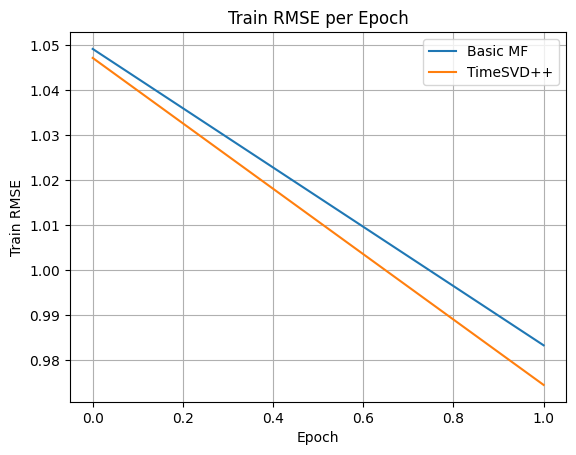

In [ ]:
# Plot train RMSE per epoch
plt.plot(basic_rmse, label='Basic MF')
plt.plot(timesvd_rmse, label='TimeSVD++')
plt.xlabel('Epoch')
plt.ylabel('Train RMSE')
plt.title('Train RMSE per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Experiment 9

In [ ]:
#Trust-Aware Contextual Recommendation
import numpy as np
import pandas as pd

In [ ]:
# Simulating the ratings data (User, Movie, Rating)
ratings_data = {
    'user': [0, 0, 1, 1, 2, 3, 4, 4, 5, 6, 7, 7, 8, 8, 9, 9],
    'item': [0, 1, 0, 2, 2, 1, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2],
    'rating': [4, 5, 5, 3, 2, 4, 4, 2, 5, 4, 3, 2, 5, 4, 4, 5]
}
ratings = pd.DataFrame(ratings_data)

In [ ]:
# Trust dataset: (User, Trusted User)
trust_data = {
    'user': [0, 1, 1, 2, 3, 4, 5, 6, 7, 8],
    'trusted_user': [1, 0, 2, 3, 4, 5, 6, 7, 8, 9]
}
trust = pd.DataFrame(trust_data)

In [ ]:
# Number of users and items
num_users = ratings['user'].nunique()
num_items = ratings['item'].nunique()

In [ ]:
# Creating the user-item ratings matrix (R)
R = np.zeros((num_users, num_items))
for row in ratings.itertuples():
    R[row.user, row.item] = row.rating

In [ ]:
# Create the trust matrix (1 if user trusts another, else 0)
trust_matrix = np.zeros((num_users, num_users))
for row in trust.itertuples():
    trust_matrix[row.user, row.trusted_user] = 1

In [ ]:
# Predicting rating using trust-aware weighted average
def predict_rating_trust(target_user, target_item):
    # Get the list of trusted users for the target user
    trusted_users = np.where(trust_matrix[target_user] > 0)[0]
    trusted_ratings = R[trusted_users, target_item]
    # Only consider the ratings from users who have rated the item
    trusted_ratings = trusted_ratings[trusted_ratings > 0]
    if len(trusted_ratings) == 0:
        return np.mean(R[target_user, R[target_user] > 0])  # Fallback to user average
    # Weighted sum based on trust
    numerator = sum(trust_matrix[target_user, u] * R[u, target_item] for u in trusted_users if R[u, target_item] > 0)
    denominator = sum(trust_matrix[target_user, u] for u in trusted_users if R[u, target_item] > 0)
    return numerator / denominator if denominator > 0 else np.mean(R[target_user, R[target_user] > 0])

In [ ]:
# Test: Predict ratings for user 0 on items 0, 1, 2, 3, and 4
sample_items = [0, 1, 2, 3, 4]
sample_user = 0
for item in sample_items:
    pred_rating = predict_rating_trust(sample_user, item)
    print(f"Predicted rating for user {sample_user} on item {item}: {pred_rating:.2f}")

Predicted rating for user 0 on item 0: 5.00
Predicted rating for user 0 on item 1: 4.50
Predicted rating for user 0 on item 2: 3.00
Predicted rating for user 0 on item 3: 4.50
Predicted rating for user 0 on item 4: 4.50


# Experiment 10: Mini Project

**Step 1.1: Load and Inspect Books Data**

In [ ]:
import pandas as pd

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load Books dataset
books = pd.read_csv("/content/sample_data/Books.csv", encoding="latin-1")  # Encoding to avoid errors

In [ ]:
# Display first few rows
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
# Check dataset information
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [ ]:
# Check for missing values
books.isnull().sum()

,0
ISBN,0
Book-Title,0
Book-Author,2
Year-Of-Publication,0
Publisher,2
Image-URL-S,0
Image-URL-M,0
Image-URL-L,3


**Step 1.2: Load and Inspect Users Data**

In [ ]:
# Load Users dataset
users = pd.read_csv("/content/sample_data/Users.csv", encoding="latin-1")

In [ ]:
# Display first few rows
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
# Check dataset information
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [ ]:
# Check for missing values
users.isnull().sum()

,0
User-ID,0
Location,0
Age,110762


**Step 1.3: Load and Inspect Ratings Data**

In [ ]:
# Load Ratings dataset
ratings = pd.read_csv("/content/sample_data/Ratings.csv", encoding="latin-1")

In [ ]:
# Display first few rows
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
# Check dataset information
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [ ]:
# Check for missing values
ratings.isnull().sum()

,0
User-ID,0
ISBN,0
Book-Rating,0


**Step 1.4: Statistical Summary & Data Visualization (EDA)**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Statistical summary of numerical columns
print("Statistical Summary (Users):")
users.describe()

Statistical Summary (Users):


,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


In [ ]:
print("Statistical Summary (Ratings):")
ratings.describe()

Statistical Summary (Ratings):


,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


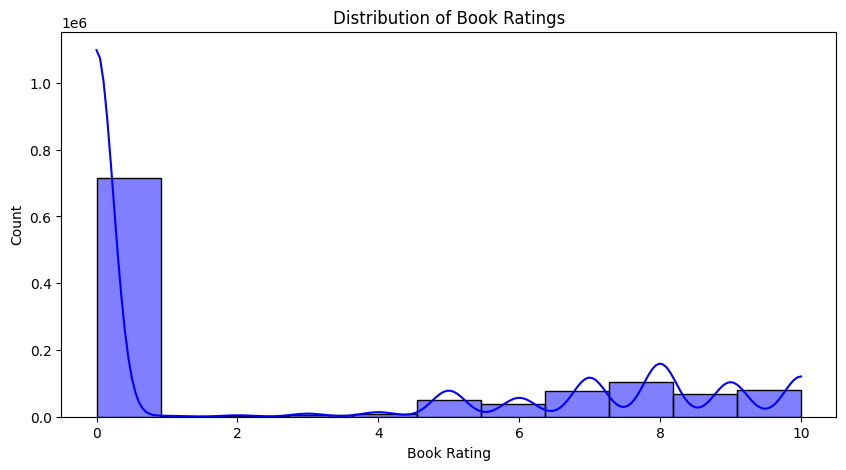

In [ ]:
# Distribution of Book Ratings
plt.figure(figsize=(10, 5))
sns.histplot(ratings['Book-Rating'], bins=11, kde=True, color="blue")
plt.xlabel("Book Rating")
plt.ylabel("Count")
plt.title("Distribution of Book Ratings")
plt.show()

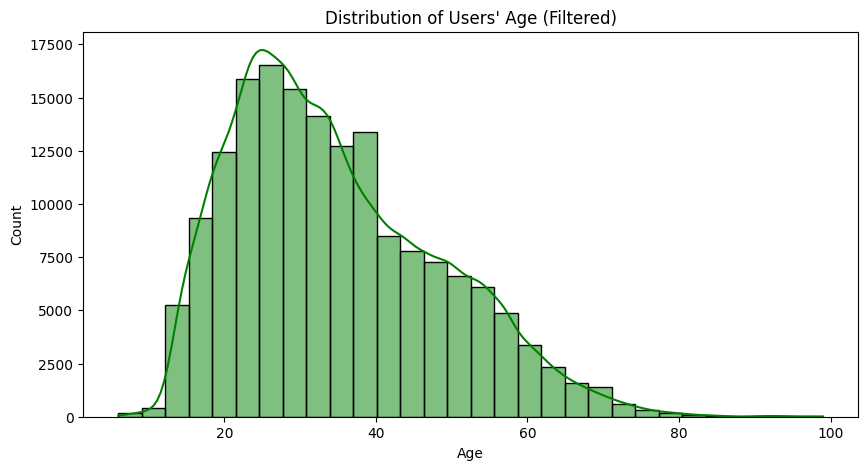

In [ ]:
# Age Distribution (with filtering unrealistic ages)
plt.figure(figsize=(10, 5))
sns.histplot(users[(users["Age"] > 5) & (users["Age"] < 100)]["Age"], bins=30, kde=True, color="green")
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Distribution of Users' Age (Filtered)")
plt.show()

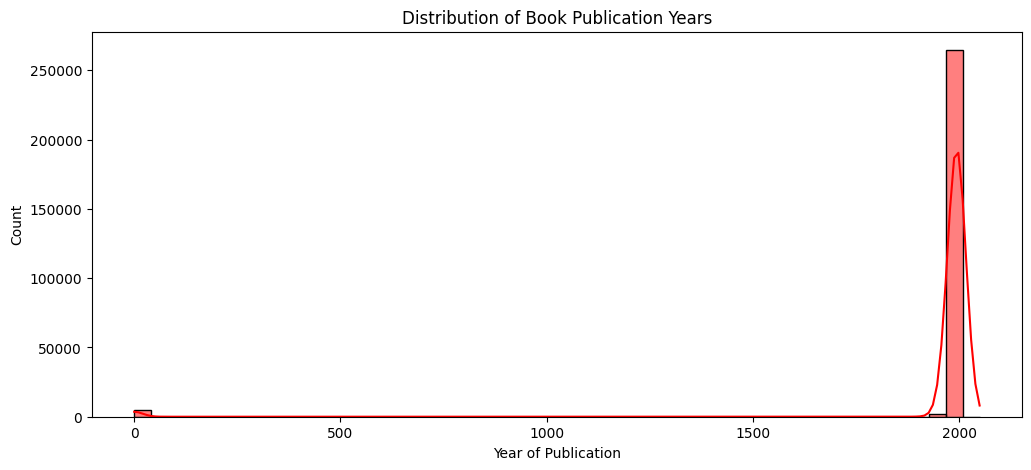

In [ ]:
# Year of Publication Distribution
plt.figure(figsize=(12, 5))
sns.histplot(books[books["Year-Of-Publication"].astype(str).str.isnumeric()]["Year-Of-Publication"].astype(int), bins=50, kde=True, color="red")
plt.xlabel("Year of Publication")
plt.ylabel("Count")
plt.title("Distribution of Book Publication Years")
plt.show()

**Step 1.5 - Inter-Analysis**

In [ ]:
ratings

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


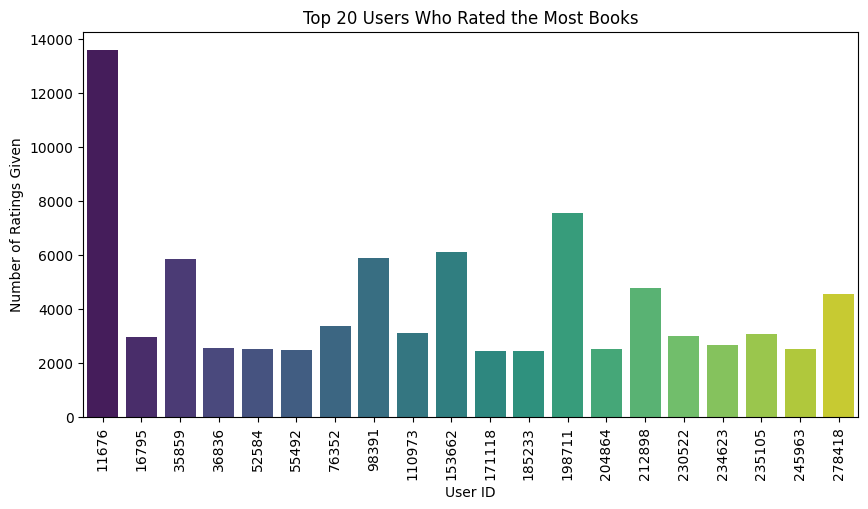

In [ ]:
# 3. Distribution of ratings per user (Top 20)
user_rating_counts = ratings["User-ID"].value_counts()[:20]
plt.figure(figsize=(10, 5))
sns.barplot(x=user_rating_counts.index, y=user_rating_counts.values, palette="viridis")
plt.xlabel("User ID")
plt.ylabel("Number of Ratings Given")
plt.title("Top 20 Users Who Rated the Most Books")
plt.xticks(rotation=90)
plt.show()

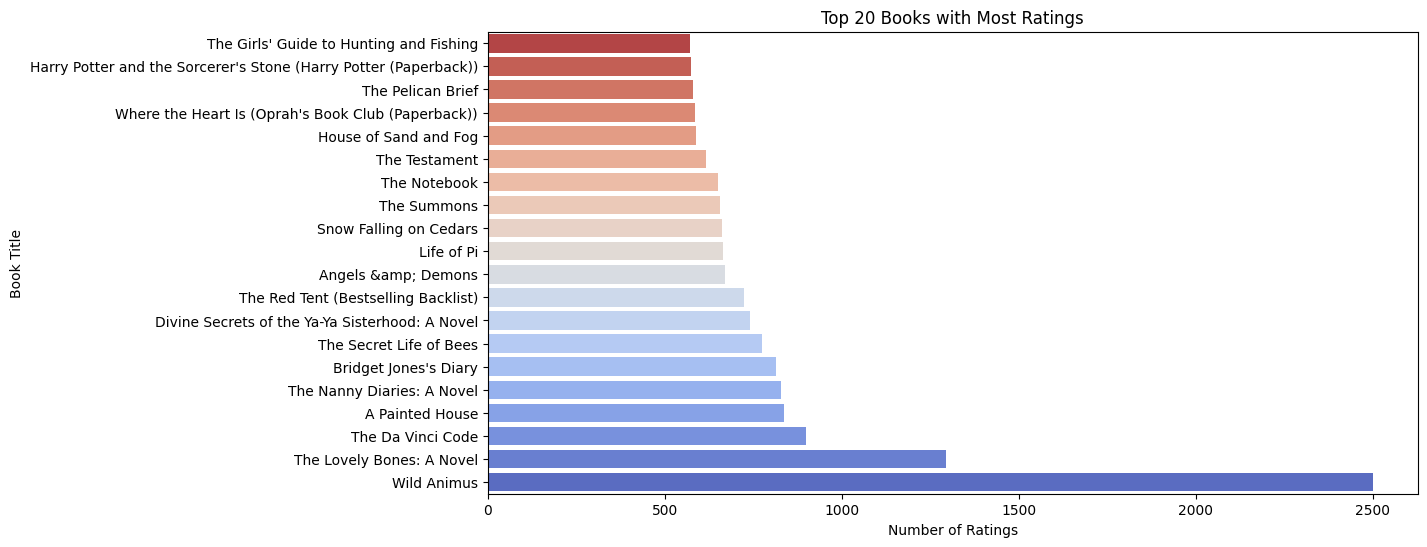

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Merge ratings with books to get book titles
ratings_with_titles = ratings.merge(books[['ISBN', 'Book-Title']], on='ISBN', how='left')
# Count the number of ratings per book
book_rating_counts = ratings_with_titles['Book-Title'].value_counts().nlargest(20)  # Get top 20 books
# Plot
plt.figure(figsize=(12, 6))
sns.barplot(y=book_rating_counts.index, x=book_rating_counts.values, palette="coolwarm")
plt.xlabel("Number of Ratings")
plt.ylabel("Book Title")
plt.title("Top 20 Books with Most Ratings")
plt.gca().invert_yaxis()  # Invert y-axis to show most-rated books on top
plt.show()

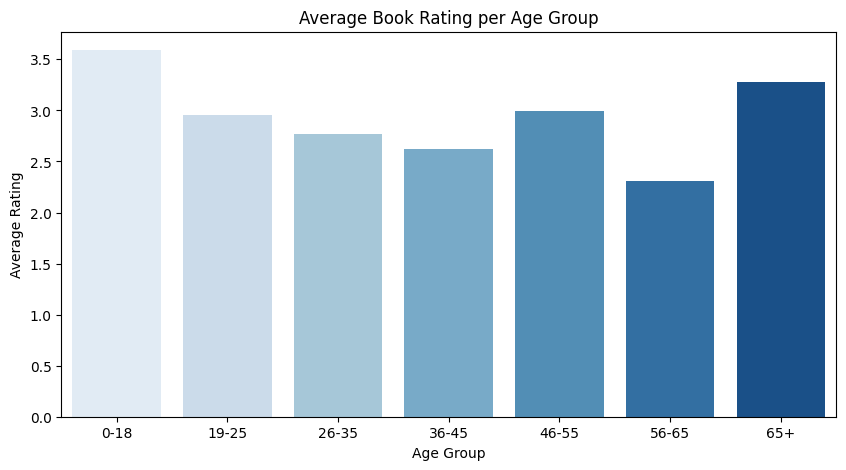

In [ ]:
# 4. Average rating per age group
user_ratings = ratings.merge(users, on="User-ID")
age_bins = [0, 18, 25, 35, 45, 55, 65, 100]
age_labels = ["0-18", "19-25", "26-35", "36-45", "46-55", "56-65", "65+"]
user_ratings["Age Group"] = pd.cut(user_ratings["Age"], bins=age_bins, labels=age_labels)
avg_rating_per_age = user_ratings.groupby("Age Group")["Book-Rating"].mean()
plt.figure(figsize=(10, 5))
sns.barplot(x=avg_rating_per_age.index, y=avg_rating_per_age.values, palette="Blues")
plt.xlabel("Age Group")
plt.ylabel("Average Rating")
plt.title("Average Book Rating per Age Group")
plt.show()

**Step 2: Preprocessing & Data Cleaning**

In [ ]:
# Check for missing values
print("Missing values in Books dataset:\n", books.isnull().sum())
print("\nMissing values in Users dataset:\n", users.isnull().sum())
print("\nMissing values in Ratings dataset:\n", ratings.isnull().sum())

Missing values in Books dataset:
 ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

Missing values in Users dataset:
 User-ID          0
Location         0
Age         110762
dtype: int64

Missing values in Ratings dataset:
 User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


In [ ]:
# Check data types
print("\nData types in Books dataset:\n", books.dtypes)
print("\nData types in Users dataset:\n", users.dtypes)
print("\nData types in Ratings dataset:\n", ratings.dtypes)


Data types in Books dataset:
 ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication    object
Publisher              object
Image-URL-S            object
Image-URL-M            object
Image-URL-L            object
dtype: object

Data types in Users dataset:
 User-ID       int64
Location     object
Age         float64
dtype: object

Data types in Ratings dataset:
 User-ID         int64
ISBN           object
Book-Rating     int64
dtype: object


In [ ]:
# Fill missing values in Books dataset
books["Book-Author"].fillna("Unknown", inplace=True)
books["Publisher"].fillna("Unknown", inplace=True)

In [ ]:
# Handle Age in Users dataset (removing unrealistic values)
users = users[(users["Age"] >= 5) & (users["Age"] <= 100)]

In [ ]:
# Check Year-Of-Publication for unrealistic values
print("Unique Years of Publication:\n", books["Year-Of-Publication"].unique())

Unique Years of Publication:
 [2002 2001 1991 1999 2000 1993 1996 1988 2004 1998 1994 2003 1997 1983
 1979 1995 1982 1985 1992 1986 1978 1980 1952 1987 1990 1981 1989 1984 0
 1968 1961 1958 1974 1976 1971 1977 1975 1965 1941 1970 1962 1973 1972
 1960 1966 1920 1956 1959 1953 1951 1942 1963 1964 1969 1954 1950 1967
 2005 1957 1940 1937 1955 1946 1936 1930 2011 1925 1948 1943 1947 1945
 1923 2020 1939 1926 1938 2030 1911 1904 1949 1932 1928 1929 1927 1931
 1914 2050 1934 1910 1933 1902 1924 1921 1900 2038 2026 1944 1917 1901
 2010 1908 1906 1935 1806 2021 '2000' '1995' '1999' '2004' '2003' '1990'
 '1994' '1986' '1989' '2002' '1981' '1993' '1983' '1982' '1976' '1991'
 '1977' '1998' '1992' '1996' '0' '1997' '2001' '1974' '1968' '1987' '1984'
 '1988' '1963' '1956' '1970' '1985' '1978' '1973' '1980' '1979' '1975'
 '1969' '1961' '1965' '1939' '1958' '1950' '1953' '1966' '1971' '1959'
 '1972' '1955' '1957' '1945' '1960' '1967' '1932' '1924' '1964' '2012'
 '1911' '1927' '1948' '1962' '2006' '19

In [ ]:
# Remove duplicates if any
books.drop_duplicates(inplace=True)
users.drop_duplicates(inplace=True)
ratings.drop_duplicates(inplace=True)

In [ ]:
print("Data cleaning completed!")

Data cleaning completed!


In [ ]:
import pandas as pd
# Ensure Year-Of-Publication is treated as numeric
books["Year-Of-Publication"] = pd.to_numeric(books["Year-Of-Publication"], errors="coerce")
# Replace invalid years with 'Unknown' or clip them to 1900-2025 range
books["Year-Of-Publication"] = books["Year-Of-Publication"].apply(lambda x: "Unknown" if pd.isna(x) or x < 1900 else (2025 if x > 2025 else int(x)))
# Display unique values to verify correction
print(books["Year-Of-Publication"].unique())

[2002 2001 1991 1999 2000 1993 1996 1988 2004 1998 1994 2003 1997 1983
 1979 1995 1982 1985 1992 1986 1978 1980 1952 1987 1990 1981 1989 1984
 'Unknown' 1968 1961 1958 1974 1976 1971 1977 1975 1965 1941 1970 1962
 1973 1972 1960 1966 1920 1956 1959 1953 1951 1942 1963 1964 1969 1954
 1950 1967 2005 1957 1940 1937 1955 1946 1936 1930 2011 1925 1948 1943
 1947 1945 1923 2020 1939 1926 1938 2025 1911 1904 1949 1932 1928 1929
 1927 1931 1914 1934 1910 1933 1902 1924 1921 1900 1944 1917 1901 2010
 1908 1906 1935 2021 2012 2006 1909 2008 1919 1922 2024]


In [ ]:
import numpy as np
# Convert to integer while keeping NaNs
books["Year-Of-Publication"] = books["Year-Of-Publication"].replace("Unknown", np.nan).astype("Int64")

In [ ]:
# Check again
print("Cleaned Unique Years of Publication:\n", books["Year-Of-Publication"].unique())

Cleaned Unique Years of Publication:
 <IntegerArray>
[2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998,
 ...
 1906, 1935, 2021, 2012, 2006, 1909, 2008, 1919, 1922, 2024]
Length: 108, dtype: Int64


In [ ]:
books.isnull().sum()

,0
ISBN,0
Book-Title,0
Book-Author,0
Year-Of-Publication,4625
Publisher,0
Image-URL-S,0
Image-URL-M,0
Image-URL-L,3


In [ ]:
# Fill missing Year-Of-Publication based on the same Book-Title
books["Year-Of-Publication"] = books.groupby("Book-Title")["Year-Of-Publication"].transform(
    lambda x: x.fillna(int(x.median()) if pd.notna(x.median()) else x)
)

In [ ]:
# If still missing, fill using the overall median (converted to int)
books["Year-Of-Publication"].fillna(int(books["Year-Of-Publication"].median()), inplace=True)

In [ ]:
# Convert column to integer (if needed)
books["Year-Of-Publication"] = books["Year-Of-Publication"].astype(int)

In [ ]:
# Fill missing values with appropriate replacements
books["Image-URL-L"].fillna("No Image Available", inplace=True)
# Verify if null values still exist
print(books.isnull().sum())

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64


In [ ]:
users.isnull().sum()

,0
User-ID,0
Location,0
Age,0


In [ ]:
ratings.isnull().sum()

,0
User-ID,0
ISBN,0
Book-Rating,0


**Weighted Average Rating (WAR)**

In [ ]:
# Compute total number of ratings and average rating per book
popularity_df = ratings.groupby('ISBN').agg({'Book-Rating': ['count', 'mean']}).reset_index()

In [ ]:
# Rename columns for better readability
popularity_df.columns = ['ISBN', 'Rating-Count', 'Average-Rating']

In [ ]:
# Display top 5 records
popularity_df.head()

,ISBN,Rating-Count,Average-Rating
0,0330299891,2,3.0
1,0375404120,2,1.5
2,0586045007,1,0.0
3,9022906116,2,3.5
4,9032803328,1,0.0


In [ ]:
# Calculate C (mean rating across all books)
C = popularity_df['Average-Rating'].mean()

In [ ]:
# Define m (minimum number of ratings required)
m = popularity_df['Rating-Count'].quantile(0.90)  # 90th percentile as a threshold

In [ ]:
# Function to compute WAR for each book
def weighted_average_rating(df, m=m, C=C):
    V = df['Rating-Count']
    R = df['Average-Rating']
    return ((V * R) + (m * C)) / (m + V)

In [ ]:
# Apply WAR calculation
popularity_df['WAR'] = popularity_df.apply(weighted_average_rating, axis=1)

In [ ]:
# Filter books that have at least 'm' ratings
qualified_books = popularity_df[popularity_df['Rating-Count'] >= m]

In [ ]:
# Sort books by WAR score
qualified_books = qualified_books.sort_values(by='WAR', ascending=False)

In [ ]:
# Merge with books dataset to get Book Titles
qualified_books = qualified_books.merge(books[['ISBN', 'Book-Title']], on='ISBN', how='left')

In [ ]:
# Select and reorder columns for display
final_recommendations = qualified_books[['Book-Title', 'Rating-Count', 'Average-Rating', 'WAR']]

In [ ]:
final_recommendations = final_recommendations.dropna(subset=['Book-Title'])

In [ ]:
# Display top 10 books
final_recommendations.head(10)

,Book-Title,Rating-Count,Average-Rating,WAR
0,Free,54,7.962963,7.461026
1,The Blue Day Book: A Lesson in Cheering Yourse...,11,9.181818,6.980092
2,Death: The High Cost of Living,9,9.444444,6.844105
3,The Baby Book: Everything You Need to Know Abo...,13,8.461538,6.719030
5,The Shrinking of Treehorn,8,9.500000,6.690112
6,A Letter to Mrs. Roosevelt,8,9.500000,6.690112
7,Marching Through Culpeper : A Novel of Culpepe...,15,8.066667,6.602932
8,There's Treasure Everywhere--A Calvin and Hobb...,17,7.882353,6.593981
9,"Le Combat ordinaire, tome 1",8,9.250000,6.547255
10,Sandman: The Dream Hunters,8,9.250000,6.547255


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

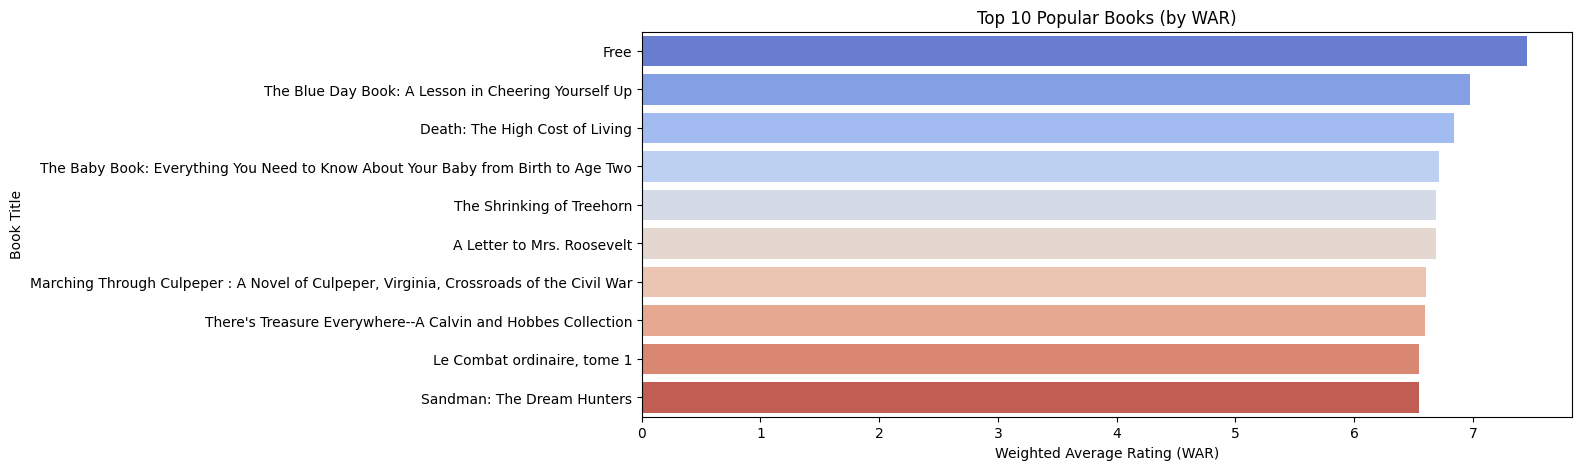

In [ ]:
# Plot the top 10 books based on WAR
plt.figure(figsize=(12, 5))
top_10_books = final_recommendations.head(10)
# Horizontal bar plot with coolwarm colormap
sns.barplot(
    x="WAR", y="Book-Title", data=top_10_books, palette="coolwarm"
)
# Titles and labels
plt.xlabel("Weighted Average Rating (WAR)")
plt.ylabel("Book Title")
plt.title("Top 10 Popular Books (by WAR)")
plt.show()

**Step 4.1: Feature Processing & Text Vectorization.**

In [ ]:
# Convert Year-Of-Publication to string (for concatenation)
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(str)

In [ ]:
# Combine selected features into a single text column
books['combined_features'] = (
    books['Book-Title'] + ' ' +
    books['Book-Author'] + ' ' +
    books['Publisher'] + ' ' +
    books['Year-Of-Publication']
).str.lower()

**Step 4.2: Text Vectorization using TF-IDF.**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Initialize TF-IDF Vectorizer (removing English stop words)
tfidf = TfidfVectorizer(stop_words='english')

In [ ]:
# Fit and transform the combined features into a TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(books['combined_features'])

In [ ]:
# Check the shape of the matrix
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)

TF-IDF Matrix Shape: (271360, 116643)


**Step 4.3: Finding Similar Books**

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
# Define model
nn_model = NearestNeighbors(metric="cosine", algorithm="brute", n_jobs=-1)

In [ ]:
# Fit model to TF-IDF matrix
nn_model.fit(tfidf_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1)

In [ ]:
book_idx = 0  # Example: Find similar books to the first book

In [ ]:
distances, indices = nn_model.kneighbors(tfidf_matrix[book_idx], n_neighbors=11)

In [ ]:
# Convert indices to book titles
similar_books = books.iloc[indices[0][1:]]  # Skip first one (it's the book itself)

In [ ]:
similar_books[["Book-Title", "Book-Author"]]

,Book-Title,Book-Author
193923,Classical mythology,Mark P. O Morford
111977,Classical mythology,Mark P.O Morford
95231,Classical Mythology,Mark P. O. Morford
205930,Who's Who in Classical Mythology (Who's Who Se...,Michael Grant
54275,The Oxford Classical Dictionary,Simon Hornblower
107089,The Oxford Companion to Classical Literature (...,Paul H. Harvey
189499,The Oxford Companion to Classical Civilization,Simon Hornblower
189495,The Oxford History of the Classical World,Oswyn Murray
186147,Goddesses in World Mythology,Martha Ann
271140,The Dictionary of Classical Mythology,JOHN EDWARD ZIMMERMAN


**Content-Based Filtering**

In [ ]:
from sklearn.metrics.pairwise import linear_kernel

In [ ]:
def get_recommendations(book_title, books, tfidf_matrix, top_n=10):
    # Ensure book title exists in the dataset
    if book_title not in books['Book-Title'].values:
        return f"Sorry, '{book_title}' is not found in the dataset."
    # Get the index of the book
    idx = books[books['Book-Title'] == book_title].index[0]
    # Compute similarity scores **ONLY for this book**
    sim_scores = linear_kernel(tfidf_matrix[idx], tfidf_matrix).flatten()
    # Get the top N similar books (excluding itself)
    similar_indices = sim_scores.argsort()[::-1][1:]  # Exclude the first (itself)
    # Get recommended book titles (remove duplicates while keeping order)
    recommended_books = []
    seen_titles = set()
    for i in similar_indices:
        title = books.iloc[i]['Book-Title']
        if title not in seen_titles:
            recommended_books.append(title)
            seen_titles.add(title)
        if len(recommended_books) == top_n:  # Stop when we have enough unique books
            break
    # Format output
    return f"Since you liked '{book_title}', you might also like: " + ", ".join(recommended_books) + "."

In [ ]:
# Example usage:
book_title = "The Hobbit"
print(get_recommendations(book_title, books, tfidf_matrix))

Since you liked 'The Hobbit', you might also like: The Hobbit, The Hobbit: Or There and Back Again, Lo Hobbit / The Hobbit, The Annotated Hobbit: The Hobbit, Or, There and Back Again, Hobbit, The Hobbit: or There and Back Again, The Hobbit: Or, There and Back Again, Poems from The Hobbit, El Hobbit, The Hobbit (Illustrated Edition).


**User-Based Collaborative Filtering**

In [ ]:
from scipy.sparse import coo_matrix

In [ ]:
# Convert User-ID and ISBN to numerical indices for sparse matrix
user_mapping = {id: idx for idx, id in enumerate(ratings['User-ID'].unique())}
book_mapping = {isbn: idx for idx, isbn in enumerate(ratings['ISBN'].unique())}

In [ ]:
ratings['user_idx'] = ratings['User-ID'].map(user_mapping)
ratings['book_idx'] = ratings['ISBN'].map(book_mapping)

In [ ]:
# Create sparse matrix
user_item_sparse = coo_matrix(
    (ratings['Book-Rating'], (ratings['user_idx'], ratings['book_idx']))
)

In [ ]:
print("Sparse User-Item Matrix shape:", user_item_sparse.shape)

Sparse User-Item Matrix shape: (105283, 340556)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Compute cosine similarity between users (sparse format)
user_sim_matrix = cosine_similarity(user_item_sparse, dense_output=False)

In [ ]:
print("User-User Similarity Matrix computed!")

User-User Similarity Matrix computed!


In [ ]:
user_sim_matrix.shape

(105283, 105283)

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import numpy as np
from scipy.sparse import coo_matrix
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

In [ ]:
def get_recommendations_for_user(user_id, book_title, books, ratings, user_sim_matrix, user_mapping, book_mapping, top_n=10):
    """
    Generates book recommendations for an existing or new user.
    Returns: (recommendations, updated_user_sim_matrix)
    """
    idx_to_user = {v: k for k, v in user_mapping.items()}  # Reverse mapping for user indices

    # 🔥 Check if user exists
    if user_id in user_mapping:
        print(f"Existing user found! Generating recommendations for User-ID {user_id}...")

        user_idx = user_mapping[user_id]  # Get user index

        # ✅ Ensure user_idx is within bounds before accessing the similarity matrix
        if user_idx >= user_sim_matrix.shape[0]:
            print("User similarity matrix is outdated. Updating...")
            user_item_sparse = coo_matrix(
                (ratings['Book-Rating'], (ratings['user_idx'], ratings['book_idx']))
            )
            user_sim_matrix = cosine_similarity(user_item_sparse, dense_output=False)  # 🔥 Update similarity matrix

        # Now fetch recommendations
        similar_users = np.argsort(user_sim_matrix[user_idx].toarray().flatten())[::-1][1:top_n+1]
        similar_users_ids = [idx_to_user[idx] for idx in similar_users]
        similar_users_ratings = ratings[ratings['User-ID'].isin(similar_users_ids)]
        top_books = (similar_users_ratings.groupby('ISBN')['Book-Rating']
                     .mean().sort_values(ascending=False).head(top_n))
        recommendations = books[books['ISBN'].isin(top_books.index)][['Book-Title', 'Book-Author', 'Publisher']]
        return recommendations, user_sim_matrix  # ✅ Return updated similarity matrix

    # 🔥 If new user, add them and recompute similarity
    else:
        print(f"New user detected! Adding User-ID {user_id} to dataset...")

        book_matches = books[books['Book-Title'].str.contains(book_title, case=False, na=False)]
        if book_matches.empty:
            return "Sorry, no books found with that title.", user_sim_matrix

        selected_book = book_matches.iloc[0]
        book_isbn = selected_book['ISBN']

        new_entry = pd.DataFrame([{
            'User-ID': user_id,
            'ISBN': book_isbn,
            'Book-Rating': 5  # Assume the user gives a high rating
        }])

        # Append new user entry
        ratings = pd.concat([ratings, new_entry], ignore_index=True)

        # Update mappings
        new_user_idx = len(user_mapping)
        user_mapping[user_id] = new_user_idx
        ratings['user_idx'] = ratings['User-ID'].map(user_mapping)
        ratings['book_idx'] = ratings['ISBN'].map(book_mapping)

        # ✅ Recompute user-item sparse matrix and similarity
        user_item_sparse = coo_matrix(
            (ratings['Book-Rating'], (ratings['user_idx'], ratings['book_idx']))
        )
        user_sim_matrix = cosine_similarity(user_item_sparse, dense_output=False)  # 🔥 Update similarity matrix

        print(f"User {user_id} added with book '{book_title}'. Now generating recommendations...")

        # Find books rated by users who like this book
        interested_users = ratings[(ratings['ISBN'] == book_isbn) & (ratings['Book-Rating'] >= 7)]
        if interested_users.empty:
            return "No users have rated this book highly enough to generate recommendations.", user_sim_matrix

        recommended_books = ratings[ratings['User-ID'].isin(interested_users['User-ID'])]
        top_books = (recommended_books.groupby('ISBN')['Book-Rating']
                     .mean().sort_values(ascending=False).head(top_n))
        recommendations = books[books['ISBN'].isin(top_books.index)][['Book-Title', 'Book-Author', 'Publisher']]
        return recommendations, user_sim_matrix  # ✅ Return updated similarity matrix

In [ ]:
# Test the function
user_id = 99  # New User
book_title = "The Hobbit"
get_recommendations_for_user(user_id, book_title, books, ratings, user_sim_matrix, user_mapping, book_mapping)

Existing user found! Generating recommendations for User-ID 99...


(                                               Book-Title         Book-Author  \
 74                                             Seabiscuit   LAURA HILLENBRAND   
 101     Rich Dad, Poor Dad: What the Rich Teach Their ...  Robert T. Kiyosaki   
 103                         McDonald's: Behind the Arches        John F. Love   
 4857    Bearing an Hourglass (Incarnations of Immortal...       Piers Anthony   
 6090              How To Win Friends And Influence People       Dale Carnegie   
 35902                                    The Silent Angel       Heinrich Boll   
 85020   Between Silk and Cyanide : A Codemaker's War, ...           Leo Marks   
 88075                 Anam Cara : A Book of Celtic Wisdom      John O'Donohue   
 223249                                  The Four Wise Men     Michel Tournier   
 223250                   Friday (Pantheon Modern Writers)     Michel Tournier   
 
                              Publisher  
 74                    Ballantine Books  
 101        

**Item Based Collaborative Filtering**

**✅ Step 1: Preprocess ratings Data**

In [ ]:
import pandas as pd

In [ ]:
# Remove users who haven't rated any books
ratings_cleaned = ratings.dropna(subset=['User-ID', 'ISBN', 'Book-Rating'])

In [ ]:
# Ensure 'Book-Rating' is numeric
ratings_cleaned['Book-Rating'] = pd.to_numeric(ratings_cleaned['Book-Rating'], errors='coerce')

In [ ]:
# Drop any NaN ratings after conversion
ratings_cleaned = ratings_cleaned.dropna(subset=['Book-Rating'])

In [ ]:
# Convert to integers (some ratings might be floats after conversion)
ratings_cleaned['Book-Rating'] = ratings_cleaned['Book-Rating'].astype(int)

**✅ Step 2: Compute Item-Item Similarity Matrix**

In [ ]:
from scipy.sparse import coo_matrix
# Create book and user mappings
book_mapping = {isbn: idx for idx, isbn in enumerate(ratings_cleaned['ISBN'].unique())}
user_mapping = {uid: idx for idx, uid in enumerate(ratings_cleaned['User-ID'].unique())}
# Map the original IDs to new indices
ratings_cleaned['book_idx'] = ratings_cleaned['ISBN'].map(book_mapping)
ratings_cleaned['user_idx'] = ratings_cleaned['User-ID'].map(user_mapping)
# Create Item-User sparse matrix (Books as rows, Users as columns)
item_user_sparse = coo_matrix(
    (ratings_cleaned['Book-Rating'], (ratings_cleaned['book_idx'], ratings_cleaned['user_idx']))
)

In [ ]:
print("✅ Item-User Sparse Matrix created successfully!")
print("Shape:", item_user_sparse.shape)

✅ Item-User Sparse Matrix created successfully!
Shape: (340556, 105283)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
# Compute sparse cosine similarity
item_sim_matrix = cosine_similarity(item_user_sparse, dense_output=False).tocsc()

In [ ]:
print("Item-Item Similarity Matrix computed!")
print("Shape:", item_sim_matrix.shape)

Item-Item Similarity Matrix computed!
Shape: (340556, 340556)


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
def get_similar_books(book_title, books, book_mapping, item_sim_matrix, top_n=10):
    """
    Recommends books similar to a given book using Item-Based Collaborative Filtering.
    """
    # Find the book's ISBN
    book_matches = books[books['Book-Title'].str.contains(book_title, case=False, na=False)]
    if book_matches.empty:
        return "❌ No books found with that title."
    selected_book = book_matches.iloc[0]  # Pick the first match
    book_isbn = selected_book['ISBN']
    # Check if ISBN exists in book_mapping
    if book_isbn not in book_mapping:
        return "❌ Book not found in the dataset."
    book_idx = book_mapping[book_isbn]  # Get book index
    # Get similarity scores for the book
    similar_books = np.argsort(item_sim_matrix[book_idx].toarray().flatten())[::-1][1:top_n+1]
    # Get ISBNs of similar books
    similar_isbns = [isbn for isbn, idx in book_mapping.items() if idx in similar_books]
    # Retrieve book details
    recommended_books = books[books['ISBN'].isin(similar_isbns)][['Book-Title', 'Book-Author', 'Publisher']]
    return recommended_books if not recommended_books.empty else "❌ No recommendations found."

In [ ]:
book_title = "The Four Wise Men"  # Example book title
recommendations = get_similar_books(book_title, books, book_mapping, item_sim_matrix)
print(f"Thank you for selecting {book_title}! You many also like:")
recommendations

Thank you for selecting The Four Wise Men! You many also like:


,Book-Title,Book-Author,Publisher
101,"Rich Dad, Poor Dad: What the Rich Teach Their ...",Robert T. Kiyosaki,Warner Books
1431,The Silmarillion,J.R.R. TOLKIEN,Del Rey
35902,The Silent Angel,Heinrich Boll,Picador USA
97921,Nightwatch,Richard P. Henrick,HarperTorch
97953,Please Shoot Dog Can,Jackie Cooper,Berkley Publishing Group
97969,"Dark Waters (Harlequin Superromance, No. 438)",Jane Silverwood,Harlequin
97970,"Bright Secrets (Superromance, No 442)",Jane Silverwood,Harlequin
223249,The Four Wise Men,Michel Tournier,Johns Hopkins University Press


**WAR threshold:**

In [ ]:
def weighted_average_rating(df, m, C):
    V = df['Rating_Count']  # Corrected column name
    R = df['Average_Rating']
    return ((V * R) + (m * C)) / (m + V)

In [ ]:
# Compute average rating and count per book
book_stats = ratings.groupby('ISBN').agg(Average_Rating=('Book-Rating', 'mean'), Rating_Count=('Book-Rating', 'count')).reset_index()

In [ ]:
# Define minimum ratings threshold (e.g., 50)
m = book_stats['Rating_Count'].quantile(0.90)  # 90th percentile
C = book_stats['Average_Rating'].mean()  # Global average rating

In [ ]:
# Compute WAR
book_stats['Weighted Average Rating'] = weighted_average_rating(book_stats, m=m, C=C)

In [ ]:
# Now, store WAR as a DataFrame
WAR = book_stats[['ISBN', 'Weighted Average Rating']]

In [ ]:
def get_item_based_recommendations(book_title, books, ratings, item_sim_matrix, book_mapping, war_threshold=2.5, top_n=10):
    """
    Generates book recommendations based on Item-Based Collaborative Filtering.
    """
    # Check if the book exists
    book_matches = books[books['Book-Title'].str.contains(book_title, case=False, na=False)]
    if book_matches.empty:
        return "Sorry, no books found with that title."
    # Pick the first matching book
    selected_book = book_matches.iloc[0]
    book_isbn = selected_book['ISBN']
    # Ensure the book exists in the mapping
    if book_isbn not in book_mapping:
        return "This book is not in our recommendation system."
    book_idx = book_mapping[book_isbn]
    # Get similarity scores for the book
    similar_books_indices = np.argsort(item_sim_matrix[book_idx].toarray().flatten())[::-1][1:top_n+1]
    similar_books_isbns = [list(book_mapping.keys())[list(book_mapping.values()).index(idx)] for idx in similar_books_indices]
    # Get recommended books' details
    recommended_books = books[books['ISBN'].isin(similar_books_isbns)].copy()
    # Merge with WAR DataFrame
    recommended_books = recommended_books.merge(WAR, on="ISBN", how="left")
    # **Apply WAR threshold filter**
    recommended_books = recommended_books[recommended_books["Weighted Average Rating"] >= war_threshold]
    # Select required columns
    return recommended_books[['Book-Title', 'Book-Author', 'Publisher', 'Weighted Average Rating']].sort_values(by="Weighted Average Rating", ascending=False)

In [ ]:
book_title = "The Hobbit"
recommendations = get_item_based_recommendations(book_title, books, ratings, item_sim_matrix, book_mapping)
print(f"Thank you for selecting {book_title}! You many also like:")
recommendations

Thank you for selecting The Hobbit! You many also like:


,Book-Title,Book-Author,Publisher,Weighted Average Rating
0,The Lord of the Rings (Leatherette Collector's...,J. R. R. Tolkien,Houghton Mifflin Company,6.471797
2,"The Return of the King (The Lord of the Rings,...",J. R. R. Tolkien,Houghton Mifflin Co,5.295730
3,The Two Towers (Lord of the Rings (Hardcover)),J. R. R. Tolkien,Houghton Mifflin Company,5.295730
4,The Fellowship of the Ring: Being the First Pa...,J. R. R. Tolkien,Houghton Mifflin Co,4.184619
7,Palladium Books Presents: Palladium Fantasy Ro...,Kevin Siembieda,Palladium Books,3.951653
6,Dynamic HTML: The Definitive Reference,Danny Goodman,O'Reilly,3.629063
9,C Programming in 12 Easy Lessons,Greg Perry,Prentice Hall,3.523081
8,"Electronic Fundamentals: Circuits, Devices, an...",Thomas L. Floyd,Prentice Hall,3.523081
1,The Reckoning,SHARON KAY PENMAN,Ballantine Books,3.332969
5,Portrait of the Artist's Wife,Barbara Anderson,W W Norton &amp; Co Inc,2.707696


**Hybrid Based Recommendation System**

**Step 1: Compute Content Similarity Matrix**

In [ ]:
def get_content_based_recommendations(book_title, books, tfidf):
    """Compute similarity for a single book instead of all books"""
    book_idx = books.index[books["Book-Title"] == book_title].tolist()
    if not book_idx:
        return []
    book_idx = book_idx[0]  # Get the index of the book
    book_vector = tfidf_matrix[book_idx]  # Now it's a matrix, not a Vectorizer
    similarity_scores = cosine_similarity(book_vector, tfidf_matrix).flatten()

    # Get top 10 most similar books (excluding itself)
    similar_indices = similarity_scores.argsort()[::-1][1:11]
    return books.iloc[similar_indices][["Book-Title", "Book-Author", "Publisher"]]

**Step 2: Run the Hybrid Model**

In [ ]:
# Calculate Weighted Average Rating for each book
book_ratings = ratings.groupby('ISBN')['Book-Rating'].agg(['mean', 'count'])
book_ratings.rename(columns={'mean': 'Average Rating', 'count': 'Rating Count'}, inplace=True)

# Before merging, drop the columns if they already exist in 'books'
books = books.drop(columns=['Average Rating', 'Rating Count'], errors='ignore')

# Merge with books DataFrame (after dropping potential duplicates)
books = pd.merge(books, book_ratings, on='ISBN', how='left')

# Calculate Weighted Average Rating
C = books['Average Rating'].mean()  # Global average rating
m = books['Rating Count'].quantile(0.90)  # Minimum votes required to be in the chart

def weighted_rating(x, m=m, C=C):
    v = x['Rating Count']
    R = x['Average Rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

books['Weighted Average Rating'] = books.apply(weighted_rating, axis=1)

In [ ]:
def get_item_based_recommendations(book_title, books, ratings, item_sim_matrix, book_mapping, war_threshold=6.5, top_n=10):
    """
    Recommends books based on item-based collaborative filtering using similarity scores.

    Args:
        book_title (str): Title of the book to get recommendations for.
        books (pd.DataFrame): DataFrame containing book information (including 'Book-Title', 'ISBN', and 'Weighted Average Rating').
        ratings (pd.DataFrame): DataFrame containing user ratings for books.
        item_sim_matrix (np.ndarray): Item-item similarity matrix.
        book_mapping (dict): Mapping of ISBN to book titles.
        war_threshold (float, optional): Minimum weighted average rating for a recommended book. Defaults to 6.5.
        top_n (int, optional): Number of top recommendations to return. Defaults to 10.

    Returns:
        pd.DataFrame: DataFrame containing the recommended books (or the top-rated books if the given book is not found).
    """
    # Normalize the book title as well
    book_title = book_title.lower()

    # Check if the book title exists in the dataset
    if book_title not in book_mapping.values():
        print(f"⚠️ Book '{book_title}' not found in dataset. Returning popular books.")
        return books[['Book-Title', 'Book-Author', 'Publisher', 'Weighted Average Rating']].sort_values(by="Weighted Average Rating", ascending=False).head(top_n)

    # Get the index (row number) of the book in the similarity matrix
    book_index = list(book_mapping.keys())[list(book_mapping.values()).index(book_title)]
    isbn = list(book_mapping.keys())[list(book_mapping.values()).index(book_title)]

    # Get the similarity scores for this book with all other books
    similarity_scores = list(enumerate(item_sim_matrix[book_index]))

    # Sort books based on similarity scores
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Get the top similar books (excluding the book itself)
    similarity_scores = similarity_scores[1:11]

    # Get the indices of the recommended books
    book_indices = [i[0] for i in similarity_scores]

    # Get the ISBNs of the recommended books
    recommended_books_isbn = [list(book_mapping.keys())[i] for i in book_indices]

    # Get the recommended books from the books DataFrame using ISBNs
    recommended_books = books[books["ISBN"].isin(recommended_books_isbn)]

    # Merge with Weighted Average Rating (WAR)
    WAR = books[["ISBN", "Weighted Average Rating"]]
    recommended_books = recommended_books.merge(WAR, on="ISBN", how="left")

    # **Apply WAR threshold filter**
    recommended_books = recommended_books[recommended_books["Weighted Average Rating"] >= war_threshold]

    # Select required columns
    return recommended_books[['Book-Title', 'Book-Author', 'Publisher', 'Weighted Average Rating']].sort_values(by="Weighted Average Rating", ascending=False)

In [ ]:
# Compute Weighted Average Rating if missing
if 'Weighted Average Rating' not in books.columns:
    print("⚠️ 'Weighted Average Rating' missing in books. Fixing...")

    # Calculate average rating for each book
    books_avg_ratings = ratings.groupby('ISBN')['Book-Rating'].mean().reset_index()
    books_avg_ratings.rename(columns={'Book-Rating': 'Weighted Average Rating'}, inplace=True)

    books = books.merge(books_avg_ratings, on='ISBN', how='left')

In [ ]:
# Ensure input_book is defined
if 'input_book' not in locals():
    input_book = ""  # Default value if it's not set

In [ ]:
# Normalize user input title as well
input_book = input_book.lower()

In [ ]:
def get_user_based_recommendations(user_id, ratings, user_sim_matrix, book_mapping, user_mapping, top_n=10):
    print(f"🔍 Available Users in user_mapping: {list(user_mapping.keys())[:5]} ...")

    if user_id not in user_mapping:
        print(f"⚠️ User {user_id} not found. Returning popular books instead.")
        return books[['Book-Title', 'Book-Author', 'Publisher', 'Weighted Average Rating']].sort_values(by="Weighted Average Rating", ascending=False).head(top_n)

    user_idx = user_mapping[user_id]

    # Get user similarity scores
    user_similarities = user_sim_matrix[user_idx].toarray().flatten()
    similar_users = np.argsort(user_similarities)[::-1][1:11]

    # Get books rated by similar users
    similar_users_ids = [list(user_mapping.keys())[i] for i in similar_users]
    recommended_books = ratings[ratings['User-ID'].isin(similar_users_ids)]
    recommended_books = recommended_books.groupby('ISBN').mean()['Book-Rating'].reset_index()

    # Ensure book_mapping is a DataFrame before merging
    book_mapping_df = pd.DataFrame(book_mapping.items(), columns=['ISBN', 'Book-Title'])
    recommended_books = recommended_books.merge(book_mapping_df, on='ISBN', how='left')

    return recommended_books[['Book-Title', 'Book-Rating']].sort_values(by='Book-Rating', ascending=False).head(top_n)

In [ ]:
def hybrid_recommendations(book_title, user_id, books, ratings, user_sim_matrix, item_sim_matrix, book_mapping, user_mapping, tfidf_matrix):
    print(f"📌 Generating recommendations for User: {user_id}, Book: '{book_title}'")

    # User-Based CF
    user_based_recommendations = get_user_based_recommendations(user_id, ratings, user_sim_matrix, book_mapping, user_mapping)

    # Item-Based CF
    item_based_recommendations = get_item_based_recommendations(book_title, books, ratings, item_sim_matrix, book_mapping)

    # Content-Based Filtering
    content_based_recommendations = get_content_based_recommendations(book_title, books, tfidf_matrix)

    # Ensure all recommendations are DataFrames
    user_based_recommendations = pd.DataFrame(user_based_recommendations)
    item_based_recommendations = pd.DataFrame(item_based_recommendations)
    content_based_recommendations = pd.DataFrame(content_based_recommendations)

    # Combine all recommendations
    hybrid_results = pd.concat([user_based_recommendations, item_based_recommendations, content_based_recommendations], ignore_index=True).drop_duplicates()

    if hybrid_results.empty:
        print("⚠️ No hybrid recommendations found. Returning popular books.")
        return books[['Book-Title', 'Book-Author', 'Publisher', 'Weighted Average Rating']].sort_values(by="Weighted Average Rating", ascending=False).head(10)

    return hybrid_results

In [ ]:
# -------------------- EXAMPLE USAGE --------------------
book_title = "the hobbit"
user_id = 278851

# Ensure 'books' DataFrame has the correct columns
if 'Weighted Average Rating' not in books.columns:
    print("⚠️ 'Weighted Average Rating' missing in books. Fixing...")
    books['Weighted Average Rating'] = books.get('Weighted Average Rating', np.nan)

# Call hybrid recommendations function
recommendations = hybrid_recommendations(
    book_title, user_id, books, ratings, user_sim_matrix, item_sim_matrix, book_mapping, user_mapping, tfidf_matrix
)

# Print recommendations
print("\n📚 Recommended Books:")
recommendations.dropna(subset=['Weighted Average Rating'], inplace=True)
recommendations

📌 Generating recommendations for User: 278851, Book: 'the hobbit'
🔍 Available Users in user_mapping: [np.int64(276725), np.int64(276726), np.int64(276727), np.int64(276729), np.int64(276733)] ...
⚠️ Book 'the hobbit' not found in dataset. Returning popular books.

📚 Recommended Books:


,Book-Title,Book-Rating,Book-Author,Publisher,Weighted Average Rating
10,Free,NaN,Paul Vincent,Upfront Publishing,7.380172
11,The Blue Day Book: A Lesson in Cheering Yourse...,NaN,Bradley Trevor Greive,Random House Australia,6.732804
12,Death: The High Cost of Living,NaN,Neil Gaiman,DC Comics,6.574404
13,The Baby Book: Everything You Need to Know Abo...,NaN,Martha Sears,"Little, Brown",6.509524
14,Harry Potter and the Chamber of Secrets (Book 2),NaN,J. K. Rowling,Scholastic,6.464353
15,There's Treasure Everywhere--A Calvin and Hobb...,NaN,Bill Watterson,Andrews McMeel Publishing,6.424603
16,Marching Through Culpeper : A Novel of Culpepe...,NaN,Virginia Beard Morton,Edgehill Books,6.417749
17,Harry Potter and the Goblet of Fire (Book 4),NaN,J. K. Rowling,Scholastic,6.413883
18,A Letter to Mrs. Roosevelt,NaN,C. COCO DE YOUNG,Delacorte Books for Young Readers,6.412698
19,The Shrinking of Treehorn,NaN,Florence Parry Heide,Holiday House,6.412698


In [ ]:
users.head()

,User-ID,Location,Age
1,2,"stockton, california, usa",18.0
3,4,"porto, v.n.gaia, portugal",17.0
5,6,"santa monica, california, usa",61.0
9,10,"albacete, wisconsin, spain",26.0
10,11,"melbourne, victoria, australia",14.0


**Region Based Recommender Systems**

In [ ]:
# Function to extract the last part of location as country
def extract_country(location):
    parts = location.split(",")
    return parts[-1].strip() if len(parts) > 1 else location.strip()

In [ ]:
# Apply the function to extract the country
users['Country'] = users['Location'].apply(extract_country)

In [ ]:
# Display results
users.head()

,User-ID,Location,Age,Country
1,2,"stockton, california, usa",18.0,usa
3,4,"porto, v.n.gaia, portugal",17.0,portugal
5,6,"santa monica, california, usa",61.0,usa
9,10,"albacete, wisconsin, spain",26.0,spain
10,11,"melbourne, victoria, australia",14.0,australia


In [ ]:
def hybrid_recommendations_with_location(book_title, user_id, books, ratings, user_sim_matrix, item_sim_matrix, book_mapping, user_mapping, tfidf_matrix, users):
    print(f"📌 Generating personalized recommendations for User: {user_id}, Book: '{book_title}'")

    # Check if user exists
    if user_id not in user_mapping:
        print(f"⚠️ User {user_id} not found. Returning top-rated books globally.")
        return books.nlargest(10, 'Weighted Average Rating')

    # Extract user country
    user_country = users.loc[users['User-ID'] == user_id, 'Country'].values[0]
    print(f"🌍 User is from: {user_country}")

    # Get books highly rated in the user's country
    country_ratings = ratings.merge(users[['User-ID', 'Country']], on='User-ID')
    country_ratings = country_ratings[country_ratings['Country'] == user_country]

    # Aggregate ratings for books in the same country
    country_book_ratings = country_ratings.groupby('ISBN')['Book-Rating'].mean().reset_index()
    country_book_ratings.rename(columns={'Book-Rating': 'Country-Avg-Rating'}, inplace=True)

    # Merge with books dataset
    books = books.merge(country_book_ratings, on='ISBN', how='left')

    # Fill missing values with global average rating
    global_avg_rating = books['Weighted Average Rating'].mean()
    books['Country-Avg-Rating'].fillna(global_avg_rating, inplace=True)

    # ✅ **Prioritize books highly rated in user's country**
    books['Final-Score'] = (0.7 * books['Country-Avg-Rating']) + (0.3 * books['Weighted Average Rating'])

    # Sort recommendations
    personalized_recommendations = books.nlargest(10, 'Final-Score')

    return personalized_recommendations[['Book-Title', 'Book-Author', 'Publisher', 'Final-Score']]

# Example usage
personalized_recs = hybrid_recommendations_with_location('the hobbit', 10, books, ratings, user_sim_matrix, item_sim_matrix, book_mapping, user_mapping, tfidf_matrix, users)
personalized_recs

📌 Generating personalized recommendations for User: 10, Book: 'the hobbit'
🌍 User is from: spain


,Book-Title,Book-Author,Publisher,Final-Score
12762,"The Two Towers (The Lord of the Rings, Part 2)",J. R. R. Tolkien,Houghton Mifflin Company,8.716460
1932,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,Starscape Books,8.627381
88306,LA Metamorfosis (Colecci?on Literaria Lyc (Lee...,Franz Kafka,Ediciones Colihue,8.505714
12761,"The Return of the King (The Lord of The Rings,...",J. R. R. Tolkien,Houghton Mifflin Company,8.493061
138999,The Complete Robot,Isaac Asimov,Harper Collins - UK,8.479762
71532,"Poetry of Robert Frost: The Collected Poems, C...",Robert Frost,Henry Holt &amp; Company,8.477922
28317,L'Affaire Tournesol / Calculus Affair (Tintin),Herge,Casterman,8.475714
47181,How to Marry a Marquis (Avon Romantic Treasure),Julia Quinn,Avon,8.466071
13659,501 Spanish Verbs: Fully Conjugated in All the...,Christopher Kendris,Barron's Educational Series,8.454762
2021,Ishmael: An Adventure of the Mind and Spirit,Daniel Quinn,Bantam,8.447084


In [ ]:
country_book_ratings = ratings.merge(users[['User-ID', 'Country']], on='User-ID')
country_book_ratings = country_book_ratings.groupby(['ISBN', 'Country'])['Book-Rating'].mean().reset_index()
country_book_ratings.rename(columns={'Book-Rating': 'Country-Avg-Rating'}, inplace=True)

In [ ]:
country_book_ratings = country_book_ratings[country_book_ratings['Country-Avg-Rating'] > 0]

In [ ]:
# Ensure ISBNs are treated as strings and strip unwanted characters
country_book_ratings['ISBN'] = country_book_ratings['ISBN'].astype(str).str.replace(r"[^0-9Xx]", "", regex=True)

In [ ]:
# Find the most popular books per country
top_books_by_country = country_book_ratings.sort_values(['Country', 'Country-Avg-Rating'], ascending=[True, False])

In [ ]:
# Display sample results
print(top_books_by_country.head(10))

            ISBN Country  Country-Avg-Rating
1128   000617501                        10.0
2086  0006513220                        10.0
3105  0007140676                        10.0
3358    00170415                        10.0
3421  0020197802                        10.0
3615  0020442203                        10.0
3786  0020891415                        10.0
4333   002861673                        10.0
4628  0029190959                        10.0
5371  0060005556                        10.0


In [ ]:
# Group by Country and ISBN, compute the average rating
country_ratings_grouped = (
    country_book_ratings.groupby(['Country', 'ISBN'])['Country-Avg-Rating']
    .mean()
    .reset_index()
)

# Sort within each country by highest average rating
top_books_by_country = country_ratings_grouped.sort_values(by=['Country', 'Country-Avg-Rating'], ascending=[True, False])

# Display top 10 books for different countries
print(top_books_by_country.groupby('Country').head(10))


           Country        ISBN  Country-Avg-Rating
6                    000617501                10.0
14                  0006513220                10.0
30                  0007140676                10.0
32                    00170415                10.0
33                  0020197802                10.0
...            ...         ...                 ...
177739  yugoslavia  185326895X                 8.0
177736  yugoslavia  0862788498                 7.0
177737  yugoslavia  0971880107                 1.0
177744      zambia  0671042858                 7.0
177745    zimbabwe  0812544714                 8.0

[1217 rows x 3 columns]


In [ ]:
# Drop rows where 'Country' is empty or null
country_book_ratings = country_book_ratings.dropna(subset=['Country'])

In [ ]:
# Trim spaces and standardize country names
country_book_ratings['Country'] = country_book_ratings['Country'].str.strip().str.lower()

In [ ]:
# Check unique country values to verify correctness
print("Unique Countries in Dataset:")
print(country_book_ratings['Country'].unique())

Unique Countries in Dataset:
['netherlands' 'greece' 'south africa' 'usa' 'malaysia' 'france'
 'united kingdom' 'switzerland' 'spain' 'australia' 'argentina' 'portugal'
 'new zealand' 'canada' 'england' 'iran' 'united state' 'singapore'
 'austria' '' 'india' 'japan' 'italy' 'germany' 'trinidad and tobago'
 'belgium' 'brazil' 'ireland' 'sweden' 'hungary' 'indonesia'
 'dominican republic' 'philippines' 'bulgaria' 'egypt' 'samoa' 'denmark'
 'hong kong' 'finland' 'norway' 'kuwait' 'turkey' 'poland' 'new zealand"'
 'bahamas' 'thailand' 'czech republic' 'italia' 'china' 'romania' 'u.s.a.'
 'iceland' 'taiwan' 'israel' 'costa rica' 'far away...' 'universe'
 'united states' 'guam' 'phillipines' 'slovenia' 'n/a - on the road'
 'luxembourg' 'qatar' 'cape verde' 'colombia' 'bermuda' 'afghanistan'
 'south korea' 'mexico' 'uruguay' 'jamaica' 'cyprus' 'grenada' 'america'
 'euskal herria' 'kenya' 'brunei' 'everywhere and anywhere' 'barbados'
 'croatia' 'slovakia' 'catalonia' 'deutschland' 'x' 'guernse

In [ ]:
def get_user_country(user_id):
    """
    Retrieves the user's country from the users dataset.
    If the country is missing, prompt the user to enter it.
    """
    user_info = users[users['User-ID'] == user_id]

    if user_info.empty or pd.isna(user_info['Country'].values[0]):
        # If the user is not found or country is missing, ask for input
        user_country = input(f"User {user_id} country not found. Please enter your country: ").strip().lower()
    else:
        user_country = user_info['Country'].values[0].strip().lower()

    return user_country

In [ ]:
def recommend_books_by_region(user_id, book_title):
    """
    Generates personalized book recommendations based on the user's region.
    """
    print(f"📌 Generating personalized recommendations for User: {user_id}, Book: '{book_title}'")

    # Get user's country
    user_country = get_user_country(user_id)
    print(f"🌍 User is from: {user_country}")

    # Filter country-specific book ratings
    country_books = country_book_ratings[country_book_ratings['Country'].str.lower() == user_country]

    if country_books.empty:
        print("⚠️ No books found for this region. Defaulting to global recommendations.")
        return recommend_hybrid(user_id, book_title)

    # Get top-rated books in the user's country
    top_books = country_books.sort_values(by="Country-Avg-Rating", ascending=False).head(10)

    # Merge with books dataset to get titles and authors
    recommended_books = top_books.merge(books, on="ISBN", how="left")[['Book-Title', 'Book-Author', 'Publisher', 'Country-Avg-Rating']]

    # Drop rows where 'Book-Title' is NaN
    recommended_books = recommended_books.dropna(subset=['Book-Title'])

    print("📚 Top Books Recommended in Your Region:")
    return recommended_books


In [ ]:
# Example Usage
recommend_books_by_region(user_id=10, book_title="The Hobbit")

📌 Generating personalized recommendations for User: 10, Book: 'The Hobbit'
🌍 User is from: spain
📚 Top Books Recommended in Your Region:


,Book-Title,Book-Author,Publisher,Country-Avg-Rating
1,Daughter of Fortune : A Novel (Oprah's Book Cl...,Isabel Allende,HarperCollins,10.0
2,Lying on the Couch : A Novel,Irvin D. Yalom,Perennial,10.0
3,V. (Perennial Classics),Thomas Pynchon,Perennial Classics,10.0
4,Gamiani (La Sonrisa Vertical),Alfred De Musset,Tusquets USA Pub,10.0
5,Sin Plumas,Woody Allen,Tusquets,10.0
7,Alguien que anda por ahÃÂ­ y otros relatos (L...,Julio CortÃÂ¡zar,Ediciones Alfaguara,10.0
8,La Historia Interminable/the Neverending Story,Michael Ende,Lectorum Pubns (Juv),10.0
9,En la distancia,Josefina Aldecoa,Alfaguara/Santillana USA,10.0
